In [1]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD
# !pip install requirements.txt

In [2]:
import numpy as np

import src.dataset as dataset
import src.config as config 
from src.utils import *
import src.models as models
import src.losses as loss

path = config.TRAIN_PATCHES_FOLDER
%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
if 'google.colab' in str(get_ipython()):
  use_colab = True
  print('Running on CoLab')
else:
  use_colab = False
  print('Not running on CoLab')

Not running on CoLab


In [5]:
source_dir = './data/training/patches'

if use_colab:
    # Read file from Colab Notebook
    from google.colab import drive
    drive.mount('/content/drive')
    config.MODEL_WEIGHTS = "/content/drive/My Drive/Colab Notebooks/SKADC1"
    config.IMAGE_PATH = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/560Mhz_1000h.fits"
    config.TRAIN_DATA_FOLDER = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset"
    config.TRAIN_PATCHES_FOLDER = "/content/drive/My Drive/Colab Notebooks/SKADC1/patches"
    source_dir = "/content/drive/My Drive/Colab Notebooks/SKADC1/asset/patches"

In [6]:
# Choose the feature extraction model
backbone='baseline_44'
# backbone='baseline_16'
# backbone='vgg16'

if backbone=='baseline_16':
    # config.patch_dim = 50
    config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 4
    config.num_rois = 16
    config.anchor_box_scales = [4, 8, 16, 24, 32, 64] # anchors in the original image size
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
elif backbone=='baseline_44':
    config.patch_dim = 20
    config.resizePatch = True
    config.rpn_stride = 8
    config.num_rois = 16
    config.anchor_box_scales = [4, 8, 16, 24, 32, 64]
    config.resizeFinalDim = 100
    input_shape_1 = config.resizeFinalDim
else:
    config.patch_dim = 100
    config.resizePatch = True
    config.rpn_stride = 16
    config.num_rois = 16
    config.resizeFinalDim = 600
    input_shape_1=config.resizeFinalDim
    config.anchor_box_scales = [32,64,128]
    config.in_out_img_size_ratio = config.rpn_stride

config.anchor_num = len(config.anchor_box_ratios)*len(config.anchor_box_scales)
input_shape_2=(None, 4)
use_focal_loss = True

checkpoint = get_model_last_checkpoint(backbone)
print(f'Model last checkpoint: {checkpoint}')

file_path = f'{config.MODEL_WEIGHTS}/{backbone}'
print(f'Writing configuration on txt file: {config.MODEL_WEIGHTS}/config.txt')

if not os.path.exists(file_path):
        os.makedirs(file_path)
        
f = open(f'{file_path}/config.txt',"w+")
f.write(f'backbone = {backbone}\n config.patch_dim = {config.patch_dim}\n config.resizePatch = {config.resizePatch}\n config.rpn_stride = {config.rpn_stride}\n config.num_rois = {config.num_rois}\n config.anchor_box_scales = {config.anchor_box_scales}\n config.resizeFinalDim = {config.resizeFinalDim}\n input_shape_1 = {input_shape_1}')
f.close()

Checking model checkpoints in directory /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_44
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/baseline_44/map_63_frcnn_baseline_44.h5
Model last checkpoint: map_63_frcnn_baseline_44.h5
Writing configuration on txt file: /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/model/config.txt


Dataset shape: (19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


  0%|          | 0/19222 [00:00<?, ?it/s]

Loading FITS file /Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/data/training/560Mhz_1000h.fits


100%|██████████| 19222/19222 [00:02<00:00, 7126.82it/s]


Initial dataset shape: (19222, 15)
Found 0 boxes with zero area
Rows to be deleted: 0
New dataset shape: (19222, 15)
Extending dataset with new computed columns...
Final cleaned dataset shape: (19222, 26)

Enlarging bboxes...
DONE - Enlarging bboxes...


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height,area_orig,area_cropped,class_label
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,19710.764566,17719.170105,6.264429,6.218255,5.734349,12.503792,12.461712,155.818657,155.818657,1_1
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,18509.603417,17209.564571,110.037236,44.503323,3.338082,216.538139,97.294352,21067.937901,21067.937901,1_1
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,16498.009965,18512.295208,5.738106,4.389739,4.827354,8.820318,11.444852,100.947234,100.947234,1_1
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18023.322729,18184.661968,3.031418,2.541842,6.050027,6.014593,5.140670,30.919039,30.919039,2_1
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18128.789688,18604.884928,4.236891,2.929772,4.869573,5.937378,8.419429,49.989332,49.989332,1_1



----------
Starting training image preprocessing...

Computing max and min pixel value in order to scale image to RGB range
Max pixel value = 0.0065856808796525
Min pixel value = -1.9004022533408715e-06
Removing negative noise...
Converting to RGB...
Removing positive noise and rescaling to 0-255 interval...

Mean and stdev of the half-gaussian that best fits with noise distribution:
mu=4.561610766868865e-14, stdev=4.5037468510513567e-07
End of training image preprocessing.


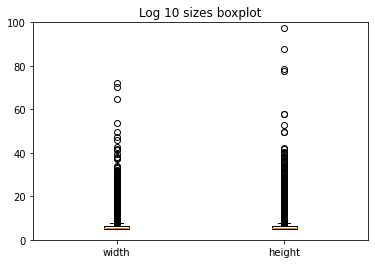

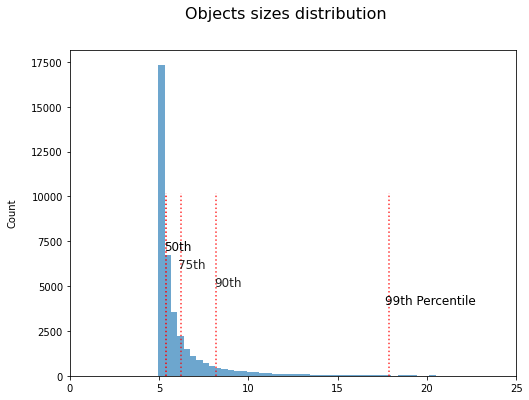

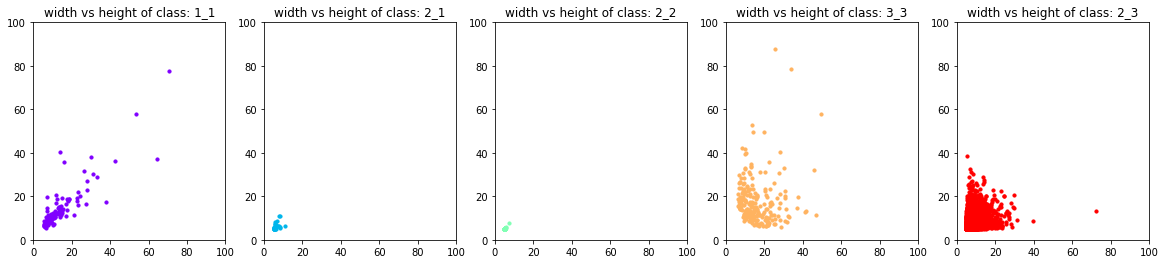

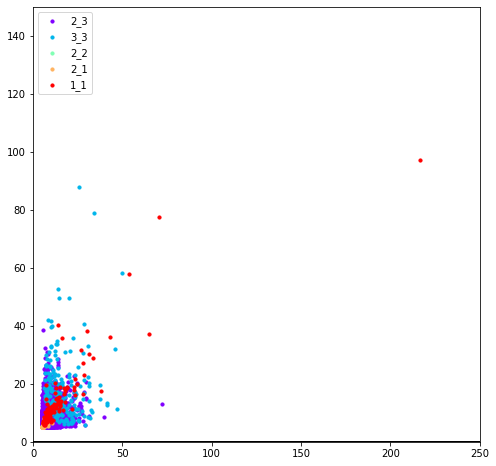

In [7]:
# Dataset parsing and loading
# use "subset" in config file to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(print_info=False, show_plot=True)

In [8]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig', 'area_cropped']].describe()

,width,height,area_orig,area_cropped
count,19222.000000,19222.000000,19222.000000,19222.000000
mean,6.282190,6.285123,44.731314,44.731314
std,3.122242,2.910949,169.529219,169.529219
min,4.964839,4.964839,24.649628,24.649628
25%,5.114121,5.116855,26.770928,26.770928
50%,5.388071,5.394034,29.928541,29.928541
75%,6.193903,6.206960,39.145862,39.145862
max,216.538139,97.294352,21067.937901,21067.937901


In [9]:
ska_dataset.cleaned_train_df[['width', 'height', 'area_orig']].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.98,.99,1.])

,width,height,area_orig
0.10,5.021579,5.022318,25.628098
0.20,5.079478,5.083666,26.354817
0.30,5.153434,5.154979,27.221580
0.40,5.250224,5.256348,28.358833
0.50,5.388071,5.394034,29.928541
0.60,5.596149,5.603978,32.164977
0.70,5.931373,5.932616,36.070023
0.80,6.568193,6.603042,43.494231
0.90,8.241342,8.188366,63.754795
0.95,10.577456,10.646052,100.988437


In [10]:
objects_to_ignore=[20167150, 27514971]

In [11]:
# Use at max limit=3969 for vgg16

ska_dataset.generate_patches(limit=10000, plot_patches=False, objects_to_ignore=objects_to_ignore, source_dir=source_dir, rgb_norm=True)

Attention: by using limit parameter you will retrieve only the first 10000 patches

Retrieving patch 2_16396_16729_20

Retrieving patch 3_16406_16729_20

Retrieving patch 6_16436_16729_20

Retrieving patch 7_16446_16729_20

Retrieving patch 8_16456_16729_20

Retrieving patch 10_16476_16729_20

Retrieving patch 11_16486_16729_20

Retrieving patch 12_16496_16729_20

Retrieving patch 13_16506_16729_20

Retrieving patch 36_16736_16729_20

Retrieving patch 37_16746_16729_20

Retrieving patch 41_16786_16729_20

Retrieving patch 42_16796_16729_20

Retrieving patch 44_16816_16729_20

Retrieving patch 45_16826_16729_20

Retrieving patch 46_16836_16729_20

Retrieving patch 47_16846_16729_20

Retrieving patch 50_16876_16729_20

Retrieving patch 51_16886_16729_20

Retrieving patch 59_16966_16729_20

Retrieving patch 60_16976_16729_20

Retrieving patch 61_16986_16729_20

Retrieving patch 62_16996_16729_20

Retrieving patch 65_17026_16729_20

Retrieving patch 66_17036_16729_20

Retrieving patch 71_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 161_16396_16739_20

Retrieving patch 162_16406_16739_20

Retrieving patch 165_16436_16739_20

Retrieving patch 166_16446_16739_20

Retrieving patch 167_16456_16739_20

Retrieving patch 169_16476_16739_20

Retrieving patch 170_16486_16739_20

Retrieving patch 171_16496_16739_20

Retrieving patch 172_16506_16739_20

Retrieving patch 173_16516_16739_20

Retrieving patch 191_16696_16739_20

Retrieving patch 192_16706_16739_20

Retrieving patch 193_16716_16739_20

Retrieving patch 194_16726_16739_20

Retrieving patch 195_16736_16739_20

Retrieving patch 196_16746_16739_20

Retrieving patch 200_16786_16739_20

Retrieving patch 201_16796_16739_20

Retrieving patch 203_16816_16739_20

Retrieving patch 204_16826_16739_20

Retrieving patch 205_16836_16739_20

Retrieving patch 206_16846_16739_20

Retrieving patch 209_16876_16739_20

Retrieving patch 210_16886_16739_20

Retrieving patch 211_16896_16739_20

Retrieving patch 213_16916_16739_20

Retrieving patch 214_16926_16739_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 224_17026_16739_20

Retrieving patch 225_17036_16739_20

Retrieving patch 230_17086_16739_20

Retrieving patch 231_17096_16739_20

Retrieving patch 232_17106_16739_20

Retrieving patch 233_17116_16739_20

Retrieving patch 245_17236_16739_20

Retrieving patch 246_17246_16739_20

Retrieving patch 251_17296_16739_20

Retrieving patch 252_17306_16739_20

Retrieving patch 253_17316_16739_20

Retrieving patch 258_17366_16739_20

Retrieving patch 330_16496_16749_20

Retrieving patch 331_16506_16749_20

Retrieving patch 332_16516_16749_20

Retrieving patch 342_16616_16749_20

Retrieving patch 343_16626_16749_20

Retrieving patch 345_16646_16749_20

Retrieving patch 346_16656_16749_20

Retrieving patch 350_16696_16749_20

Retrieving patch 351_16706_16749_20

Retrieving patch 352_16716_16749_20

Retrieving patch 353_16726_16749_20

Retrieving patch 358_16776_16749_20

Retrieving patch 359_16786_16749_20

Retrieving patch 362_16816_16749_20

Retrieving patch 363_16826_16749_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 373_16926_16749_20

Retrieving patch 375_16946_16749_20

Retrieving patch 376_16956_16749_20

Retrieving patch 380_16996_16749_20

Retrieving patch 381_17006_16749_20

Retrieving patch 387_17066_16749_20

Retrieving patch 388_17076_16749_20

Retrieving patch 391_17106_16749_20

Retrieving patch 392_17116_16749_20

Retrieving patch 396_17156_16749_20

Retrieving patch 397_17166_16749_20

Retrieving patch 398_17176_16749_20

Retrieving patch 401_17206_16749_20

Retrieving patch 402_17216_16749_20

Retrieving patch 404_17236_16749_20

Retrieving patch 405_17246_16749_20

Retrieving patch 406_17256_16749_20

Retrieving patch 407_17266_16749_20

Retrieving patch 408_17276_16749_20

Retrieving patch 409_17286_16749_20

Retrieving patch 410_17296_16749_20

Retrieving patch 489_16496_16759_20

Retrieving patch 490_16506_16759_20

Retrieving patch 491_16516_16759_20

Retrieving patch 496_16566_16759_20

Retrieving patch 497_16576_16759_20

Retrieving patch 498_16586_16759_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 505_16656_16759_20

Retrieving patch 508_16686_16759_20

Retrieving patch 509_16696_16759_20

Retrieving patch 513_16736_16759_20

Retrieving patch 514_16746_16759_20

Retrieving patch 517_16776_16759_20

Retrieving patch 518_16786_16759_20

Retrieving patch 522_16826_16759_20

Retrieving patch 523_16836_16759_20

Retrieving patch 524_16846_16759_20

Retrieving patch 525_16856_16759_20

Retrieving patch 529_16896_16759_20

Retrieving patch 530_16906_16759_20

Retrieving patch 531_16916_16759_20

Retrieving patch 532_16926_16759_20

Retrieving patch 534_16946_16759_20

Retrieving patch 535_16956_16759_20

Retrieving patch 536_16966_16759_20

Retrieving patch 537_16976_16759_20

Retrieving patch 539_16996_16759_20

Retrieving patch 540_17006_16759_20

Retrieving patch 541_17016_16759_20

Retrieving patch 546_17066_16759_20

Retrieving patch 547_17076_16759_20

Retrieving patch 555_17156_16759_20

Retrieving patch 556_17166_16759_20

Retrieving patch 557_17176_16759_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 567_17276_16759_20

Retrieving patch 568_17286_16759_20

Retrieving patch 569_17296_16759_20

Retrieving patch 570_17306_16759_20

Retrieving patch 571_17316_16759_20

Retrieving patch 638_16396_16769_20

Retrieving patch 648_16496_16769_20

Retrieving patch 649_16506_16769_20

Retrieving patch 655_16566_16769_20

Retrieving patch 656_16576_16769_20

Retrieving patch 657_16586_16769_20

Retrieving patch 658_16596_16769_20

Retrieving patch 659_16606_16769_20

Retrieving patch 660_16616_16769_20

Retrieving patch 661_16626_16769_20

Retrieving patch 662_16636_16769_20

Retrieving patch 664_16656_16769_20

Retrieving patch 665_16666_16769_20

Retrieving patch 667_16686_16769_20

Retrieving patch 668_16696_16769_20

Retrieving patch 672_16736_16769_20

Retrieving patch 673_16746_16769_20

Retrieving patch 681_16826_16769_20

Retrieving patch 682_16836_16769_20

Retrieving patch 685_16866_16769_20

Retrieving patch 686_16876_16769_20

Retrieving patch 688_16896_16769_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 696_16976_16769_20

Retrieving patch 698_16996_16769_20

Retrieving patch 699_17006_16769_20

Retrieving patch 700_17016_16769_20

Retrieving patch 703_17046_16769_20

Retrieving patch 704_17056_16769_20

Retrieving patch 708_17096_16769_20

Retrieving patch 709_17106_16769_20

Retrieving patch 710_17116_16769_20

Retrieving patch 711_17126_16769_20

Retrieving patch 715_17166_16769_20

Retrieving patch 716_17176_16769_20

Retrieving patch 724_17256_16769_20

Retrieving patch 725_17266_16769_20

Retrieving patch 726_17276_16769_20

Retrieving patch 727_17286_16769_20

Retrieving patch 729_17306_16769_20

Retrieving patch 730_17316_16769_20

Retrieving patch 731_17326_16769_20

Retrieving patch 732_17336_16769_20

Retrieving patch 735_17366_16769_20

Retrieving patch 797_16396_16779_20

Retrieving patch 807_16496_16779_20

Retrieving patch 816_16586_16779_20

Retrieving patch 817_16596_16779_20

Retrieving patch 818_16606_16779_20

Retrieving patch 819_16616_16779_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 844_16866_16779_20

Retrieving patch 845_16876_16779_20

Retrieving patch 849_16916_16779_20

Retrieving patch 850_16926_16779_20

Retrieving patch 852_16946_16779_20

Retrieving patch 853_16956_16779_20

Retrieving patch 857_16996_16779_20

Retrieving patch 858_17006_16779_20

Retrieving patch 862_17046_16779_20

Retrieving patch 863_17056_16779_20

Retrieving patch 864_17066_16779_20

Retrieving patch 867_17096_16779_20

Retrieving patch 868_17106_16779_20

Retrieving patch 869_17116_16779_20

Retrieving patch 870_17126_16779_20

Retrieving patch 871_17136_16779_20

Retrieving patch 872_17146_16779_20

Retrieving patch 873_17156_16779_20

Retrieving patch 874_17166_16779_20

Retrieving patch 875_17176_16779_20

Retrieving patch 876_17186_16779_20

Retrieving patch 882_17246_16779_20

Retrieving patch 883_17256_16779_20

Retrieving patch 888_17306_16779_20

Retrieving patch 889_17316_16779_20

Retrieving patch 890_17326_16779_20

Retrieving patch 891_17336_16779_20



/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 977_16606_16789_20

Retrieving patch 984_16676_16789_20

Retrieving patch 985_16686_16789_20

Retrieving patch 990_16736_16789_20

Retrieving patch 991_16746_16789_20

Retrieving patch 992_16756_16789_20

Retrieving patch 993_16766_16789_20

Retrieving patch 994_16776_16789_20

Retrieving patch 996_16796_16789_20

Retrieving patch 997_16806_16789_20

Retrieving patch 999_16826_16789_20

Retrieving patch 1000_16836_16789_20

Retrieving patch 1002_16856_16789_20

Retrieving patch 1003_16866_16789_20

Retrieving patch 1004_16876_16789_20

Retrieving patch 1007_16906_16789_20

Retrieving patch 1008_16916_16789_20

Retrieving patch 1009_16926_16789_20

Retrieving patch 1011_16946_16789_20

Retrieving patch 1012_16956_16789_20

Retrieving patch 1013_16966_16789_20

Retrieving patch 1015_16986_16789_20

Retrieving patch 1016_16996_16789_20

Retrieving patch 1021_17046_16789_20

Retrieving patch 1022_17056_16789_20

Retrieving patch 1023_17066_16789_20

Retrieving patch 1024_

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1031_17146_16789_20

Retrieving patch 1032_17156_16789_20

Retrieving patch 1033_17166_16789_20

Retrieving patch 1034_17176_16789_20

Retrieving patch 1035_17186_16789_20

Retrieving patch 1037_17206_16789_20

Retrieving patch 1038_17216_16789_20

Retrieving patch 1041_17246_16789_20

Retrieving patch 1042_17256_16789_20

Retrieving patch 1044_17276_16789_20

Retrieving patch 1045_17286_16789_20

Retrieving patch 1047_17306_16789_20

Retrieving patch 1048_17316_16789_20

Retrieving patch 1126_16506_16799_20

Retrieving patch 1127_16516_16799_20

Retrieving patch 1135_16596_16799_20

Retrieving patch 1136_16606_16799_20

Retrieving patch 1137_16616_16799_20

Retrieving patch 1138_16626_16799_20

Retrieving patch 1142_16666_16799_20

Retrieving patch 1143_16676_16799_20

Retrieving patch 1144_16686_16799_20

Retrieving patch 1145_16696_16799_20

Retrieving patch 1146_16706_16799_20

Retrieving patch 1147_16716_16799_20

Retrieving patch 1148_16726_16799_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1155_16796_16799_20

Retrieving patch 1156_16806_16799_20

Retrieving patch 1158_16826_16799_20

Retrieving patch 1159_16836_16799_20

Retrieving patch 1160_16846_16799_20

Retrieving patch 1161_16856_16799_20

Retrieving patch 1162_16866_16799_20

Retrieving patch 1163_16876_16799_20

Retrieving patch 1165_16896_16799_20

Retrieving patch 1166_16906_16799_20

Retrieving patch 1167_16916_16799_20

Retrieving patch 1171_16956_16799_20

Retrieving patch 1172_16966_16799_20

Retrieving patch 1174_16986_16799_20

Retrieving patch 1175_16996_16799_20

Retrieving patch 1177_17016_16799_20

Retrieving patch 1178_17026_16799_20

Retrieving patch 1180_17046_16799_20

Retrieving patch 1181_17056_16799_20

Retrieving patch 1182_17066_16799_20

Retrieving patch 1183_17076_16799_20

Retrieving patch 1184_17086_16799_20

Retrieving patch 1185_17096_16799_20

Retrieving patch 1186_17106_16799_20

Retrieving patch 1196_17206_16799_20

Retrieving patch 1197_17216_16799_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1206_17306_16799_20

Retrieving patch 1207_17316_16799_20

Retrieving patch 1208_17326_16799_20

Retrieving patch 1209_17336_16799_20

Retrieving patch 1281_16466_16809_20

Retrieving patch 1282_16476_16809_20

Retrieving patch 1283_16486_16809_20

Retrieving patch 1285_16506_16809_20

Retrieving patch 1286_16516_16809_20

Retrieving patch 1287_16526_16809_20

Retrieving patch 1288_16536_16809_20

Retrieving patch 1290_16556_16809_20

Retrieving patch 1291_16566_16809_20

Retrieving patch 1295_16606_16809_20

Retrieving patch 1296_16616_16809_20

Retrieving patch 1297_16626_16809_20

Retrieving patch 1301_16666_16809_20

Retrieving patch 1302_16676_16809_20

Retrieving patch 1304_16696_16809_20

Retrieving patch 1305_16706_16809_20

Retrieving patch 1306_16716_16809_20

Retrieving patch 1307_16726_16809_20

Retrieving patch 1310_16756_16809_20

Retrieving patch 1311_16766_16809_20

Retrieving patch 1312_16776_16809_20

Retrieving patch 1313_16786_16809_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1325_16906_16809_20

Retrieving patch 1328_16936_16809_20

Retrieving patch 1329_16946_16809_20

Retrieving patch 1330_16956_16809_20

Retrieving patch 1333_16986_16809_20

Retrieving patch 1334_16996_16809_20

Retrieving patch 1336_17016_16809_20

Retrieving patch 1337_17026_16809_20

Retrieving patch 1341_17066_16809_20

Retrieving patch 1342_17076_16809_20

Retrieving patch 1345_17106_16809_20

Retrieving patch 1346_17116_16809_20

Retrieving patch 1347_17126_16809_20

Retrieving patch 1348_17136_16809_20

Retrieving patch 1349_17146_16809_20

Retrieving patch 1356_17216_16809_20

Retrieving patch 1357_17226_16809_20

Retrieving patch 1358_17236_16809_20

Retrieving patch 1360_17256_16809_20

Retrieving patch 1361_17266_16809_20

Retrieving patch 1362_17276_16809_20

Retrieving patch 1363_17286_16809_20

Retrieving patch 1364_17296_16809_20

Retrieving patch 1367_17326_16809_20

Retrieving patch 1368_17336_16809_20

Retrieving patch 1371_17366_16809_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1446_16526_16819_20

Retrieving patch 1447_16536_16819_20

Retrieving patch 1448_16546_16819_20

Retrieving patch 1449_16556_16819_20

Retrieving patch 1450_16566_16819_20

Retrieving patch 1454_16606_16819_20

Retrieving patch 1455_16616_16819_20

Retrieving patch 1456_16626_16819_20

Retrieving patch 1457_16636_16819_20

Retrieving patch 1458_16646_16819_20

Retrieving patch 1470_16766_16819_20

Retrieving patch 1471_16776_16819_20

Retrieving patch 1475_16816_16819_20

Retrieving patch 1476_16826_16819_20

Retrieving patch 1477_16836_16819_20

Retrieving patch 1478_16846_16819_20

Retrieving patch 1482_16886_16819_20

Retrieving patch 1483_16896_16819_20

Retrieving patch 1487_16936_16819_20

Retrieving patch 1488_16946_16819_20

Retrieving patch 1489_16956_16819_20

Retrieving patch 1490_16966_16819_20

Retrieving patch 1491_16976_16819_20

Retrieving patch 1492_16986_16819_20

Retrieving patch 1493_16996_16819_20

Retrieving patch 1494_17006_16819_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1626_16736_16829_20

Retrieving patch 1627_16746_16829_20

Retrieving patch 1629_16766_16829_20

Retrieving patch 1630_16776_16829_20

Retrieving patch 1634_16816_16829_20

Retrieving patch 1635_16826_16829_20

Retrieving patch 1636_16836_16829_20

Retrieving patch 1637_16846_16829_20

Retrieving patch 1644_16916_16829_20

Retrieving patch 1645_16926_16829_20

Retrieving patch 1648_16956_16829_20

Retrieving patch 1649_16966_16829_20

Retrieving patch 1650_16976_16829_20

Retrieving patch 1652_16996_16829_20

Retrieving patch 1653_17006_16829_20

Retrieving patch 1661_17086_16829_20

Retrieving patch 1662_17096_16829_20

Retrieving patch 1663_17106_16829_20

Retrieving patch 1665_17126_16829_20

Retrieving patch 1666_17136_16829_20

Retrieving patch 1673_17206_16829_20

Retrieving patch 1674_17216_16829_20

Retrieving patch 1676_17236_16829_20

Retrieving patch 1677_17246_16829_20

Retrieving patch 1682_17296_16829_20

Retrieving patch 1683_17306_16829_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1758_16466_16839_20

Retrieving patch 1759_16476_16839_20

Retrieving patch 1761_16496_16839_20

Retrieving patch 1762_16506_16839_20

Retrieving patch 1765_16536_16839_20

Retrieving patch 1766_16546_16839_20

Retrieving patch 1767_16556_16839_20

Retrieving patch 1768_16566_16839_20

Retrieving patch 1772_16606_16839_20

Retrieving patch 1773_16616_16839_20

Retrieving patch 1774_16626_16839_20

Retrieving patch 1775_16636_16839_20

Retrieving patch 1778_16666_16839_20

Retrieving patch 1779_16676_16839_20

Retrieving patch 1785_16736_16839_20

Retrieving patch 1786_16746_16839_20

Retrieving patch 1788_16766_16839_20

Retrieving patch 1789_16776_16839_20

Retrieving patch 1791_16796_16839_20

Retrieving patch 1792_16806_16839_20

Retrieving patch 1796_16846_16839_20

Retrieving patch 1797_16856_16839_20

Retrieving patch 1803_16916_16839_20

Retrieving patch 1804_16926_16839_20

Retrieving patch 1807_16956_16839_20

Retrieving patch 1808_16966_16839_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 1820_17086_16839_20

Retrieving patch 1821_17096_16839_20

Retrieving patch 1822_17106_16839_20

Retrieving patch 1823_17116_16839_20

Retrieving patch 1824_17126_16839_20

Retrieving patch 1825_17136_16839_20

Retrieving patch 1831_17196_16839_20

Retrieving patch 1832_17206_16839_20

Retrieving patch 1833_17216_16839_20

Retrieving patch 1835_17236_16839_20

Retrieving patch 1836_17246_16839_20

Retrieving patch 1841_17296_16839_20

Retrieving patch 1842_17306_16839_20

Retrieving patch 1844_17326_16839_20

Retrieving patch 1845_17336_16839_20

Retrieving patch 1846_17346_16839_20

Retrieving patch 1847_17356_16839_20

Retrieving patch 1914_16436_16849_20

Retrieving patch 1915_16446_16849_20

Retrieving patch 1920_16496_16849_20

Retrieving patch 1921_16506_16849_20

Retrieving patch 1924_16536_16849_20

Retrieving patch 1925_16546_16849_20

Retrieving patch 1926_16556_16849_20

Retrieving patch 1927_16566_16849_20

Retrieving patch 1928_16576_16849_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2069_16396_16859_20

Retrieving patch 2070_16406_16859_20

Retrieving patch 2071_16416_16859_20

Retrieving patch 2075_16456_16859_20

Retrieving patch 2076_16466_16859_20

Retrieving patch 2079_16496_16859_20

Retrieving patch 2080_16506_16859_20

Retrieving patch 2081_16516_16859_20

Retrieving patch 2086_16566_16859_20

Retrieving patch 2087_16576_16859_20

Retrieving patch 2088_16586_16859_20

Retrieving patch 2090_16606_16859_20

Retrieving patch 2091_16616_16859_20

Retrieving patch 2092_16626_16859_20

Retrieving patch 2096_16666_16859_20

Retrieving patch 2097_16676_16859_20

Retrieving patch 2104_16746_16859_20

Retrieving patch 2105_16756_16859_20

Retrieving patch 2106_16766_16859_20

Retrieving patch 2107_16776_16859_20

Retrieving patch 2108_16786_16859_20

Retrieving patch 2109_16796_16859_20

Retrieving patch 2112_16826_16859_20

Retrieving patch 2113_16836_16859_20

Retrieving patch 2114_16846_16859_20

Retrieving patch 2115_16856_16859_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2123_16936_16859_20

Retrieving patch 2124_16946_16859_20

Retrieving patch 2125_16956_16859_20

Retrieving patch 2126_16966_16859_20

Retrieving patch 2127_16976_16859_20

Retrieving patch 2132_17026_16859_20

Retrieving patch 2133_17036_16859_20

Retrieving patch 2142_17126_16859_20

Retrieving patch 2143_17136_16859_20

Retrieving patch 2145_17156_16859_20

Retrieving patch 2146_17166_16859_20

Retrieving patch 2148_17186_16859_20

Retrieving patch 2149_17196_16859_20

Retrieving patch 2150_17206_16859_20

Retrieving patch 2153_17236_16859_20

Retrieving patch 2154_17246_16859_20

Retrieving patch 2156_17266_16859_20

Retrieving patch 2157_17276_16859_20

Retrieving patch 2158_17286_16859_20

Retrieving patch 2159_17296_16859_20

Retrieving patch 2161_17316_16859_20

Retrieving patch 2162_17326_16859_20

Retrieving patch 2163_17336_16859_20

Retrieving patch 2164_17346_16859_20

Retrieving patch 2166_17366_16859_20

Retrieving patch 2226_16376_16869_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2237_16486_16869_20

Retrieving patch 2238_16496_16869_20

Retrieving patch 2239_16506_16869_20

Retrieving patch 2240_16516_16869_20

Retrieving patch 2241_16526_16869_20

Retrieving patch 2245_16566_16869_20

Retrieving patch 2246_16576_16869_20

Retrieving patch 2247_16586_16869_20

Retrieving patch 2248_16596_16869_20

Retrieving patch 2249_16606_16869_20

Retrieving patch 2250_16616_16869_20

Retrieving patch 2251_16626_16869_20

Retrieving patch 2255_16666_16869_20

Retrieving patch 2256_16676_16869_20

Retrieving patch 2263_16746_16869_20

Retrieving patch 2264_16756_16869_20

Retrieving patch 2265_16766_16869_20

Retrieving patch 2266_16776_16869_20

Retrieving patch 2267_16786_16869_20

Retrieving patch 2268_16796_16869_20

Retrieving patch 2272_16836_16869_20

Retrieving patch 2273_16846_16869_20

Retrieving patch 2274_16856_16869_20

Retrieving patch 2275_16866_16869_20

Retrieving patch 2277_16886_16869_20

Retrieving patch 2278_16896_16869_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2290_17016_16869_20

Retrieving patch 2291_17026_16869_20

Retrieving patch 2292_17036_16869_20

Retrieving patch 2293_17046_16869_20

Retrieving patch 2301_17126_16869_20

Retrieving patch 2302_17136_16869_20

Retrieving patch 2304_17156_16869_20

Retrieving patch 2305_17166_16869_20

Retrieving patch 2307_17186_16869_20

Retrieving patch 2308_17196_16869_20

Retrieving patch 2309_17206_16869_20

Retrieving patch 2310_17216_16869_20

Retrieving patch 2311_17226_16869_20

Retrieving patch 2312_17236_16869_20

Retrieving patch 2313_17246_16869_20

Retrieving patch 2315_17266_16869_20

Retrieving patch 2316_17276_16869_20

Retrieving patch 2317_17286_16869_20

Retrieving patch 2320_17316_16869_20

Retrieving patch 2321_17326_16869_20

Retrieving patch 2322_17336_16869_20

Retrieving patch 2388_16406_16879_20

Retrieving patch 2389_16416_16879_20

Retrieving patch 2393_16456_16879_20

Retrieving patch 2394_16466_16879_20

Retrieving patch 2396_16486_16879_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2404_16566_16879_20

Retrieving patch 2405_16576_16879_20

Retrieving patch 2406_16586_16879_20

Retrieving patch 2407_16596_16879_20

Retrieving patch 2408_16606_16879_20

Retrieving patch 2409_16616_16879_20

Retrieving patch 2411_16636_16879_20

Retrieving patch 2412_16646_16879_20

Retrieving patch 2425_16776_16879_20

Retrieving patch 2426_16786_16879_20

Retrieving patch 2427_16796_16879_20

Retrieving patch 2436_16886_16879_20

Retrieving patch 2437_16896_16879_20

Retrieving patch 2440_16926_16879_20

Retrieving patch 2441_16936_16879_20

Retrieving patch 2442_16946_16879_20

Retrieving patch 2443_16956_16879_20

Retrieving patch 2444_16966_16879_20

Retrieving patch 2445_16976_16879_20

Retrieving patch 2446_16986_16879_20

Retrieving patch 2449_17016_16879_20

Retrieving patch 2450_17026_16879_20

Retrieving patch 2451_17036_16879_20

Retrieving patch 2452_17046_16879_20

Retrieving patch 2455_17076_16879_20

Retrieving patch 2456_17086_16879_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2471_17236_16879_20

Retrieving patch 2472_17246_16879_20

Retrieving patch 2475_17276_16879_20

Retrieving patch 2476_17286_16879_20

Retrieving patch 2479_17316_16879_20

Retrieving patch 2480_17326_16879_20

Retrieving patch 2481_17336_16879_20

Retrieving patch 2482_17346_16879_20

Retrieving patch 2544_16376_16889_20

Retrieving patch 2545_16386_16889_20

Retrieving patch 2547_16406_16889_20

Retrieving patch 2548_16416_16889_20

Retrieving patch 2549_16426_16889_20

Retrieving patch 2552_16456_16889_20

Retrieving patch 2553_16466_16889_20

Retrieving patch 2554_16476_16889_20

Retrieving patch 2555_16486_16889_20

Retrieving patch 2560_16536_16889_20

Retrieving patch 2561_16546_16889_20

Retrieving patch 2566_16596_16889_20

Retrieving patch 2567_16606_16889_20

Retrieving patch 2568_16616_16889_20

Retrieving patch 2569_16626_16889_20

Retrieving patch 2570_16636_16889_20

Retrieving patch 2571_16646_16889_20

Retrieving patch 2575_16686_16889_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')



Retrieving patch 2582_16756_16889_20

Retrieving patch 2585_16786_16889_20

Retrieving patch 2586_16796_16889_20

Retrieving patch 2588_16816_16889_20

Retrieving patch 2589_16826_16889_20

Retrieving patch 2599_16926_16889_20

Retrieving patch 2600_16936_16889_20

Retrieving patch 2601_16946_16889_20

Retrieving patch 2602_16956_16889_20

Retrieving patch 2603_16966_16889_20

Retrieving patch 2604_16976_16889_20

Retrieving patch 2605_16986_16889_20

Retrieving patch 2607_17006_16889_20

Retrieving patch 2608_17016_16889_20

Retrieving patch 2614_17076_16889_20

Retrieving patch 2615_17086_16889_20

Retrieving patch 2624_17176_16889_20

Retrieving patch 2625_17186_16889_20

Retrieving patch 2627_17206_16889_20

Retrieving patch 2628_17216_16889_20

Retrieving patch 2630_17236_16889_20

Retrieving patch 2631_17246_16889_20

Retrieving patch 2632_17256_16889_20

Retrieving patch 2640_17336_16889_20

Retrieving patch 2641_17346_16889_20

Retrieving patch 2703_16376_16899_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2710_16446_16899_20

Retrieving patch 2711_16456_16899_20

Retrieving patch 2712_16466_16899_20

Retrieving patch 2713_16476_16899_20

Retrieving patch 2714_16486_16899_20

Retrieving patch 2718_16526_16899_20

Retrieving patch 2719_16536_16899_20

Retrieving patch 2725_16596_16899_20

Retrieving patch 2726_16606_16899_20

Retrieving patch 2727_16616_16899_20

Retrieving patch 2728_16626_16899_20

Retrieving patch 2729_16636_16899_20

Retrieving patch 2732_16666_16899_20

Retrieving patch 2733_16676_16899_20

Retrieving patch 2734_16686_16899_20

Retrieving patch 2735_16696_16899_20

Retrieving patch 2736_16706_16899_20

Retrieving patch 2738_16726_16899_20

Retrieving patch 2739_16736_16899_20

Retrieving patch 2740_16746_16899_20

Retrieving patch 2741_16756_16899_20

Retrieving patch 2747_16816_16899_20

Retrieving patch 2748_16826_16899_20

Retrieving patch 2749_16836_16899_20

Retrieving patch 2754_16886_16899_20

Retrieving patch 2755_16896_16899_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2785_17196_16899_20

Retrieving patch 2786_17206_16899_20

Retrieving patch 2787_17216_16899_20

Retrieving patch 2788_17226_16899_20

Retrieving patch 2790_17246_16899_20

Retrieving patch 2791_17256_16899_20

Retrieving patch 2792_17266_16899_20

Retrieving patch 2793_17276_16899_20

Retrieving patch 2796_17306_16899_20

Retrieving patch 2797_17316_16899_20

Retrieving patch 2799_17336_16899_20

Retrieving patch 2800_17346_16899_20

Retrieving patch 2862_16376_16909_20

Retrieving patch 2864_16396_16909_20

Retrieving patch 2865_16406_16909_20

Retrieving patch 2868_16436_16909_20

Retrieving patch 2869_16446_16909_20

Retrieving patch 2870_16456_16909_20

Retrieving patch 2871_16466_16909_20

Retrieving patch 2872_16476_16909_20

Retrieving patch 2877_16526_16909_20

Retrieving patch 2878_16536_16909_20

Retrieving patch 2885_16606_16909_20

Retrieving patch 2886_16616_16909_20

Retrieving patch 2887_16626_16909_20

Retrieving patch 2888_16636_16909_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 2908_16836_16909_20

Retrieving patch 2910_16856_16909_20

Retrieving patch 2911_16866_16909_20

Retrieving patch 2913_16886_16909_20

Retrieving patch 2914_16896_16909_20

Retrieving patch 2920_16956_16909_20

Retrieving patch 2921_16966_16909_20

Retrieving patch 2924_16996_16909_20

Retrieving patch 2925_17006_16909_20

Retrieving patch 2931_17066_16909_20

Retrieving patch 2932_17076_16909_20

Retrieving patch 2940_17156_16909_20

Retrieving patch 2941_17166_16909_20

Retrieving patch 2944_17196_16909_20

Retrieving patch 2945_17206_16909_20

Retrieving patch 2946_17216_16909_20

Retrieving patch 2947_17226_16909_20

Retrieving patch 2951_17266_16909_20

Retrieving patch 2952_17276_16909_20

Retrieving patch 2953_17286_16909_20

Retrieving patch 2954_17296_16909_20

Retrieving patch 2955_17306_16909_20

Retrieving patch 2956_17316_16909_20

Retrieving patch 2957_17326_16909_20

Retrieving patch 2958_17336_16909_20

Retrieving patch 2959_17346_16909_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3029_16456_16919_20

Retrieving patch 3031_16476_16919_20

Retrieving patch 3032_16486_16919_20

Retrieving patch 3036_16526_16919_20

Retrieving patch 3037_16536_16919_20

Retrieving patch 3043_16596_16919_20

Retrieving patch 3044_16606_16919_20

Retrieving patch 3045_16616_16919_20

Retrieving patch 3046_16626_16919_20

Retrieving patch 3047_16636_16919_20

Retrieving patch 3055_16716_16919_20

Retrieving patch 3056_16726_16919_20

Retrieving patch 3058_16746_16919_20

Retrieving patch 3059_16756_16919_20

Retrieving patch 3060_16766_16919_20

Retrieving patch 3061_16776_16919_20

Retrieving patch 3063_16796_16919_20

Retrieving patch 3064_16806_16919_20

Retrieving patch 3066_16826_16919_20

Retrieving patch 3067_16836_16919_20

Retrieving patch 3069_16856_16919_20

Retrieving patch 3070_16866_16919_20

Retrieving patch 3071_16876_16919_20

Retrieving patch 3078_16946_16919_20

Retrieving patch 3079_16956_16919_20

Retrieving patch 3080_16966_16919_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3203_16606_16929_20

Retrieving patch 3206_16636_16929_20

Retrieving patch 3207_16646_16929_20

Retrieving patch 3208_16656_16929_20

Retrieving patch 3214_16716_16929_20

Retrieving patch 3215_16726_16929_20

Retrieving patch 3216_16736_16929_20

Retrieving patch 3217_16746_16929_20

Retrieving patch 3218_16756_16929_20

Retrieving patch 3219_16766_16929_20

Retrieving patch 3220_16776_16929_20

Retrieving patch 3222_16796_16929_20

Retrieving patch 3223_16806_16929_20

Retrieving patch 3225_16826_16929_20

Retrieving patch 3226_16836_16929_20

Retrieving patch 3229_16866_16929_20

Retrieving patch 3230_16876_16929_20

Retrieving patch 3235_16926_16929_20

Retrieving patch 3236_16936_16929_20

Retrieving patch 3237_16946_16929_20

Retrieving patch 3238_16956_16929_20

Retrieving patch 3240_16976_16929_20

Retrieving patch 3241_16986_16929_20

Retrieving patch 3242_16996_16929_20

Retrieving patch 3243_17006_16929_20

Retrieving patch 3244_17016_16929_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3252_17096_16929_20

Retrieving patch 3254_17116_16929_20

Retrieving patch 3255_17126_16929_20

Retrieving patch 3256_17136_16929_20

Retrieving patch 3257_17146_16929_20

Retrieving patch 3260_17176_16929_20

Retrieving patch 3261_17186_16929_20

Retrieving patch 3273_17306_16929_20

Retrieving patch 3274_17316_16929_20

Retrieving patch 3275_17326_16929_20

Retrieving patch 3276_17336_16929_20

Retrieving patch 3277_17346_16929_20

Retrieving patch 3278_17356_16929_20

Retrieving patch 3341_16396_16939_20

Retrieving patch 3342_16406_16939_20

Retrieving patch 3347_16456_16939_20

Retrieving patch 3348_16466_16939_20

Retrieving patch 3356_16546_16939_20

Retrieving patch 3357_16556_16939_20

Retrieving patch 3364_16626_16939_20

Retrieving patch 3365_16636_16939_20

Retrieving patch 3366_16646_16939_20

Retrieving patch 3367_16656_16939_20

Retrieving patch 3369_16676_16939_20

Retrieving patch 3370_16686_16939_20

Retrieving patch 3374_16726_16939_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3382_16806_16939_20

Retrieving patch 3384_16826_16939_20

Retrieving patch 3385_16836_16939_20

Retrieving patch 3386_16846_16939_20

Retrieving patch 3387_16856_16939_20

Retrieving patch 3388_16866_16939_20

Retrieving patch 3389_16876_16939_20

Retrieving patch 3394_16926_16939_20

Retrieving patch 3395_16936_16939_20

Retrieving patch 3396_16946_16939_20

Retrieving patch 3399_16976_16939_20

Retrieving patch 3400_16986_16939_20

Retrieving patch 3412_17106_16939_20

Retrieving patch 3413_17116_16939_20

Retrieving patch 3423_17216_16939_20

Retrieving patch 3424_17226_16939_20

Retrieving patch 3429_17276_16939_20

Retrieving patch 3430_17286_16939_20

Retrieving patch 3431_17296_16939_20

Retrieving patch 3432_17306_16939_20

Retrieving patch 3433_17316_16939_20

Retrieving patch 3434_17326_16939_20

Retrieving patch 3435_17336_16939_20

Retrieving patch 3438_17366_16939_20

Retrieving patch 3500_16396_16949_20

Retrieving patch 3501_16406_16949_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3521_16606_16949_20

Retrieving patch 3522_16616_16949_20

Retrieving patch 3523_16626_16949_20

Retrieving patch 3524_16636_16949_20

Retrieving patch 3525_16646_16949_20

Retrieving patch 3526_16656_16949_20

Retrieving patch 3527_16666_16949_20

Retrieving patch 3528_16676_16949_20

Retrieving patch 3529_16686_16949_20

Retrieving patch 3530_16696_16949_20

Retrieving patch 3531_16706_16949_20

Retrieving patch 3533_16726_16949_20

Retrieving patch 3534_16736_16949_20

Retrieving patch 3536_16756_16949_20

Retrieving patch 3537_16766_16949_20

Retrieving patch 3538_16776_16949_20

Retrieving patch 3539_16786_16949_20

Retrieving patch 3540_16796_16949_20

Retrieving patch 3541_16806_16949_20

Retrieving patch 3544_16836_16949_20

Retrieving patch 3545_16846_16949_20

Retrieving patch 3546_16856_16949_20

Retrieving patch 3556_16956_16949_20

Retrieving patch 3557_16966_16949_20

Retrieving patch 3558_16976_16949_20

Retrieving patch 3561_17006_16949_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3572_17116_16949_20

Retrieving patch 3573_17126_16949_20

Retrieving patch 3574_17136_16949_20

Retrieving patch 3575_17146_16949_20

Retrieving patch 3582_17216_16949_20

Retrieving patch 3583_17226_16949_20

Retrieving patch 3585_17246_16949_20

Retrieving patch 3586_17256_16949_20

Retrieving patch 3588_17276_16949_20

Retrieving patch 3589_17286_16949_20

Retrieving patch 3590_17296_16949_20

Retrieving patch 3591_17306_16949_20

Retrieving patch 3592_17316_16949_20

Retrieving patch 3593_17326_16949_20

Retrieving patch 3597_17366_16949_20

Retrieving patch 3657_16376_16959_20

Retrieving patch 3658_16386_16959_20

Retrieving patch 3661_16416_16959_20

Retrieving patch 3662_16426_16959_20

Retrieving patch 3674_16546_16959_20

Retrieving patch 3675_16556_16959_20

Retrieving patch 3676_16566_16959_20

Retrieving patch 3677_16576_16959_20

Retrieving patch 3680_16606_16959_20

Retrieving patch 3681_16616_16959_20

Retrieving patch 3682_16626_16959_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3687_16676_16959_20

Retrieving patch 3688_16686_16959_20

Retrieving patch 3689_16696_16959_20

Retrieving patch 3690_16706_16959_20

Retrieving patch 3692_16726_16959_20

Retrieving patch 3693_16736_16959_20

Retrieving patch 3697_16776_16959_20

Retrieving patch 3698_16786_16959_20

Retrieving patch 3699_16796_16959_20

Retrieving patch 3701_16816_16959_20

Retrieving patch 3702_16826_16959_20

Retrieving patch 3703_16836_16959_20

Retrieving patch 3704_16846_16959_20

Retrieving patch 3708_16886_16959_20

Retrieving patch 3709_16896_16959_20

Retrieving patch 3713_16936_16959_20

Retrieving patch 3714_16946_16959_20

Retrieving patch 3715_16956_16959_20

Retrieving patch 3716_16966_16959_20

Retrieving patch 3717_16976_16959_20

Retrieving patch 3720_17006_16959_20

Retrieving patch 3721_17016_16959_20

Retrieving patch 3724_17046_16959_20

Retrieving patch 3725_17056_16959_20

Retrieving patch 3726_17066_16959_20

Retrieving patch 3727_17076_16959_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3734_17146_16959_20

Retrieving patch 3739_17196_16959_20

Retrieving patch 3740_17206_16959_20

Retrieving patch 3744_17246_16959_20

Retrieving patch 3745_17256_16959_20

Retrieving patch 3747_17276_16959_20

Retrieving patch 3748_17286_16959_20

Retrieving patch 3749_17296_16959_20

Retrieving patch 3750_17306_16959_20

Retrieving patch 3751_17316_16959_20

Retrieving patch 3755_17356_16959_20

Retrieving patch 3756_17366_16959_20

Retrieving patch 3816_16376_16969_20

Retrieving patch 3817_16386_16969_20

Retrieving patch 3818_16396_16969_20

Retrieving patch 3833_16546_16969_20

Retrieving patch 3834_16556_16969_20

Retrieving patch 3835_16566_16969_20

Retrieving patch 3836_16576_16969_20

Retrieving patch 3843_16646_16969_20

Retrieving patch 3844_16656_16969_20

Retrieving patch 3845_16666_16969_20

Retrieving patch 3846_16676_16969_20

Retrieving patch 3847_16686_16969_20

Retrieving patch 3851_16726_16969_20

Retrieving patch 3852_16736_16969_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 3978_16406_16979_20

Retrieving patch 3979_16416_16979_20

Retrieving patch 3980_16426_16979_20

Retrieving patch 3981_16436_16979_20

Retrieving patch 3985_16476_16979_20

Retrieving patch 3986_16486_16979_20

Retrieving patch 3996_16586_16979_20

Retrieving patch 3997_16596_16979_20

Retrieving patch 4002_16646_16979_20

Retrieving patch 4003_16656_16979_20

Retrieving patch 4004_16666_16979_20

Retrieving patch 4013_16756_16979_20

Retrieving patch 4014_16766_16979_20

Retrieving patch 4015_16776_16979_20

Retrieving patch 4016_16786_16979_20

Retrieving patch 4017_16796_16979_20

Retrieving patch 4018_16806_16979_20

Retrieving patch 4019_16816_16979_20

Retrieving patch 4020_16826_16979_20

Retrieving patch 4022_16846_16979_20

Retrieving patch 4023_16856_16979_20

Retrieving patch 4025_16876_16979_20

Retrieving patch 4026_16886_16979_20

Retrieving patch 4029_16916_16979_20

Retrieving patch 4030_16926_16979_20

Retrieving patch 4031_16936_16979_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4038_17006_16979_20

Retrieving patch 4042_17046_16979_20

Retrieving patch 4043_17056_16979_20

Retrieving patch 4048_17106_16979_20

Retrieving patch 4049_17116_16979_20

Retrieving patch 4050_17126_16979_20

Retrieving patch 4056_17186_16979_20

Retrieving patch 4057_17196_16979_20

Retrieving patch 4058_17206_16979_20

Retrieving patch 4068_17306_16979_20

Retrieving patch 4069_17316_16979_20

Retrieving patch 4070_17326_16979_20

Retrieving patch 4071_17336_16979_20

Retrieving patch 4072_17346_16979_20

Retrieving patch 4073_17356_16979_20

Retrieving patch 4136_16396_16989_20

Retrieving patch 4137_16406_16989_20

Retrieving patch 4138_16416_16989_20

Retrieving patch 4139_16426_16989_20

Retrieving patch 4140_16436_16989_20

Retrieving patch 4144_16476_16989_20

Retrieving patch 4145_16486_16989_20

Retrieving patch 4149_16526_16989_20

Retrieving patch 4150_16536_16989_20

Retrieving patch 4155_16586_16989_20

Retrieving patch 4156_16596_16989_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4162_16656_16989_20

Retrieving patch 4163_16666_16989_20

Retrieving patch 4164_16676_16989_20

Retrieving patch 4166_16696_16989_20

Retrieving patch 4167_16706_16989_20

Retrieving patch 4172_16756_16989_20

Retrieving patch 4173_16766_16989_20

Retrieving patch 4174_16776_16989_20

Retrieving patch 4175_16786_16989_20

Retrieving patch 4176_16796_16989_20

Retrieving patch 4177_16806_16989_20

Retrieving patch 4178_16816_16989_20

Retrieving patch 4179_16826_16989_20

Retrieving patch 4181_16846_16989_20

Retrieving patch 4182_16856_16989_20

Retrieving patch 4184_16876_16989_20

Retrieving patch 4185_16886_16989_20

Retrieving patch 4188_16916_16989_20

Retrieving patch 4189_16926_16989_20

Retrieving patch 4190_16936_16989_20

Retrieving patch 4191_16946_16989_20

Retrieving patch 4192_16956_16989_20

Retrieving patch 4193_16966_16989_20

Retrieving patch 4194_16976_16989_20

Retrieving patch 4196_16996_16989_20

Retrieving patch 4197_17006_16989_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4210_17136_16989_20

Retrieving patch 4213_17166_16989_20

Retrieving patch 4214_17176_16989_20

Retrieving patch 4215_17186_16989_20

Retrieving patch 4216_17196_16989_20

Retrieving patch 4217_17206_16989_20

Retrieving patch 4218_17216_16989_20

Retrieving patch 4226_17296_16989_20

Retrieving patch 4227_17306_16989_20

Retrieving patch 4228_17316_16989_20

Retrieving patch 4229_17326_16989_20

Retrieving patch 4230_17336_16989_20

Retrieving patch 4231_17346_16989_20

Retrieving patch 4232_17356_16989_20

Retrieving patch 4296_16406_16999_20

Retrieving patch 4297_16416_16999_20

Retrieving patch 4303_16476_16999_20

Retrieving patch 4304_16486_16999_20

Retrieving patch 4308_16526_16999_20

Retrieving patch 4309_16536_16999_20

Retrieving patch 4310_16546_16999_20

Retrieving patch 4311_16556_16999_20

Retrieving patch 4315_16596_16999_20

Retrieving patch 4316_16606_16999_20

Retrieving patch 4317_16616_16999_20

Retrieving patch 4318_16626_16999_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4326_16706_16999_20

Retrieving patch 4327_16716_16999_20

Retrieving patch 4332_16766_16999_20

Retrieving patch 4333_16776_16999_20

Retrieving patch 4334_16786_16999_20

Retrieving patch 4335_16796_16999_20

Retrieving patch 4336_16806_16999_20

Retrieving patch 4337_16816_16999_20

Retrieving patch 4352_16966_16999_20

Retrieving patch 4353_16976_16999_20

Retrieving patch 4355_16996_16999_20

Retrieving patch 4356_17006_16999_20

Retrieving patch 4357_17016_16999_20

Retrieving patch 4364_17086_16999_20

Retrieving patch 4365_17096_16999_20

Retrieving patch 4368_17126_16999_20

Retrieving patch 4369_17136_16999_20

Retrieving patch 4372_17166_16999_20

Retrieving patch 4373_17176_16999_20

Retrieving patch 4375_17196_16999_20

Retrieving patch 4376_17206_16999_20

Retrieving patch 4377_17216_16999_20

Retrieving patch 4382_17266_16999_20

Retrieving patch 4383_17276_16999_20

Retrieving patch 4385_17296_16999_20

Retrieving patch 4386_17306_16999_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4392_17366_16999_20

Retrieving patch 4455_16406_17009_20

Retrieving patch 4456_16416_17009_20

Retrieving patch 4458_16436_17009_20

Retrieving patch 4459_16446_17009_20

Retrieving patch 4465_16506_17009_20

Retrieving patch 4466_16516_17009_20

Retrieving patch 4469_16546_17009_20

Retrieving patch 4470_16556_17009_20

Retrieving patch 4474_16596_17009_20

Retrieving patch 4475_16606_17009_20

Retrieving patch 4476_16616_17009_20

Retrieving patch 4477_16626_17009_20

Retrieving patch 4478_16636_17009_20

Retrieving patch 4482_16676_17009_20

Retrieving patch 4483_16686_17009_20

Retrieving patch 4485_16706_17009_20

Retrieving patch 4486_16716_17009_20

Retrieving patch 4487_16726_17009_20

Retrieving patch 4491_16766_17009_20

Retrieving patch 4492_16776_17009_20

Retrieving patch 4508_16936_17009_20

Retrieving patch 4509_16946_17009_20

Retrieving patch 4511_16966_17009_20

Retrieving patch 4512_16976_17009_20

Retrieving patch 4515_17006_17009_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4526_17116_17009_20

Retrieving patch 4529_17146_17009_20

Retrieving patch 4530_17156_17009_20

Retrieving patch 4531_17166_17009_20

Retrieving patch 4532_17176_17009_20

Retrieving patch 4533_17186_17009_20

Retrieving patch 4534_17196_17009_20

Retrieving patch 4535_17206_17009_20

Retrieving patch 4541_17266_17009_20

Retrieving patch 4542_17276_17009_20

Retrieving patch 4543_17286_17009_20

Retrieving patch 4544_17296_17009_20

Retrieving patch 4548_17336_17009_20

Retrieving patch 4549_17346_17009_20

Retrieving patch 4551_17366_17009_20

Retrieving patch 4614_16406_17019_20

Retrieving patch 4615_16416_17019_20

Retrieving patch 4617_16436_17019_20

Retrieving patch 4618_16446_17019_20

Retrieving patch 4621_16476_17019_20

Retrieving patch 4622_16486_17019_20

Retrieving patch 4624_16506_17019_20

Retrieving patch 4625_16516_17019_20

Retrieving patch 4626_16526_17019_20

Retrieving patch 4633_16596_17019_20

Retrieving patch 4634_16606_17019_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4642_16686_17019_20

Retrieving patch 4644_16706_17019_20

Retrieving patch 4645_16716_17019_20

Retrieving patch 4646_16726_17019_20

Retrieving patch 4653_16796_17019_20

Retrieving patch 4654_16806_17019_20

Retrieving patch 4655_16816_17019_20

Retrieving patch 4656_16826_17019_20

Retrieving patch 4657_16836_17019_20

Retrieving patch 4658_16846_17019_20

Retrieving patch 4661_16876_17019_20

Retrieving patch 4662_16886_17019_20

Retrieving patch 4665_16916_17019_20

Retrieving patch 4666_16926_17019_20

Retrieving patch 4667_16936_17019_20

Retrieving patch 4668_16946_17019_20

Retrieving patch 4672_16986_17019_20

Retrieving patch 4673_16996_17019_20

Retrieving patch 4674_17006_17019_20

Retrieving patch 4675_17016_17019_20

Retrieving patch 4676_17026_17019_20

Retrieving patch 4677_17036_17019_20

Retrieving patch 4683_17096_17019_20

Retrieving patch 4684_17106_17019_20

Retrieving patch 4685_17116_17019_20

Retrieving patch 4686_17126_17019_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4691_17176_17019_20

Retrieving patch 4692_17186_17019_20

Retrieving patch 4693_17196_17019_20

Retrieving patch 4694_17206_17019_20

Retrieving patch 4698_17246_17019_20

Retrieving patch 4699_17256_17019_20

Retrieving patch 4700_17266_17019_20

Retrieving patch 4702_17286_17019_20

Retrieving patch 4703_17296_17019_20

Retrieving patch 4707_17336_17019_20

Retrieving patch 4708_17346_17019_20

Retrieving patch 4710_17366_17019_20

Retrieving patch 4780_16476_17029_20

Retrieving patch 4781_16486_17029_20

Retrieving patch 4784_16516_17029_20

Retrieving patch 4785_16526_17029_20

Retrieving patch 4792_16596_17029_20

Retrieving patch 4793_16606_17029_20

Retrieving patch 4797_16646_17029_20

Retrieving patch 4798_16656_17029_20

Retrieving patch 4802_16696_17029_20

Retrieving patch 4803_16706_17029_20

Retrieving patch 4804_16716_17029_20

Retrieving patch 4807_16746_17029_20

Retrieving patch 4808_16756_17029_20

Retrieving patch 4812_16796_17029_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 4867_17346_17029_20

Retrieving patch 4869_17366_17029_20

Retrieving patch 4944_16526_17039_20

Retrieving patch 4945_16536_17039_20

Retrieving patch 4951_16596_17039_20

Retrieving patch 4952_16606_17039_20

Retrieving patch 4956_16646_17039_20

Retrieving patch 4957_16656_17039_20

Retrieving patch 4959_16676_17039_20

Retrieving patch 4960_16686_17039_20

Retrieving patch 4961_16696_17039_20

Retrieving patch 4962_16706_17039_20

Retrieving patch 4964_16726_17039_20

Retrieving patch 4965_16736_17039_20

Retrieving patch 4966_16746_17039_20

Retrieving patch 4967_16756_17039_20

Retrieving patch 4968_16766_17039_20

Retrieving patch 4969_16776_17039_20

Retrieving patch 4971_16796_17039_20

Retrieving patch 4972_16806_17039_20

Retrieving patch 4982_16906_17039_20

Retrieving patch 4983_16916_17039_20

Retrieving patch 4992_17006_17039_20

Retrieving patch 4993_17016_17039_20

Retrieving patch 4994_17026_17039_20

Retrieving patch 4995_17036_17039_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5000_17086_17039_20

Retrieving patch 5014_17226_17039_20

Retrieving patch 5015_17236_17039_20

Retrieving patch 5018_17266_17039_20

Retrieving patch 5019_17276_17039_20

Retrieving patch 5020_17286_17039_20

Retrieving patch 5022_17306_17039_20

Retrieving patch 5023_17316_17039_20

Retrieving patch 5028_17366_17039_20

Retrieving patch 5088_16376_17049_20

Retrieving patch 5089_16386_17049_20

Retrieving patch 5090_16396_17049_20

Retrieving patch 5091_16406_17049_20

Retrieving patch 5103_16526_17049_20

Retrieving patch 5104_16536_17049_20

Retrieving patch 5110_16596_17049_20

Retrieving patch 5111_16606_17049_20

Retrieving patch 5112_16616_17049_20

Retrieving patch 5113_16626_17049_20

Retrieving patch 5114_16636_17049_20

Retrieving patch 5115_16646_17049_20

Retrieving patch 5118_16676_17049_20

Retrieving patch 5119_16686_17049_20

Retrieving patch 5121_16706_17049_20

Retrieving patch 5122_16716_17049_20

Retrieving patch 5123_16726_17049_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5129_16786_17049_20

Retrieving patch 5130_16796_17049_20

Retrieving patch 5131_16806_17049_20

Retrieving patch 5144_16936_17049_20

Retrieving patch 5145_16946_17049_20

Retrieving patch 5149_16986_17049_20

Retrieving patch 5150_16996_17049_20

Retrieving patch 5151_17006_17049_20

Retrieving patch 5152_17016_17049_20

Retrieving patch 5153_17026_17049_20

Retrieving patch 5157_17066_17049_20

Retrieving patch 5158_17076_17049_20

Retrieving patch 5159_17086_17049_20

Retrieving patch 5170_17196_17049_20

Retrieving patch 5171_17206_17049_20

Retrieving patch 5172_17216_17049_20

Retrieving patch 5173_17226_17049_20

Retrieving patch 5175_17246_17049_20

Retrieving patch 5176_17256_17049_20

Retrieving patch 5177_17266_17049_20

Retrieving patch 5178_17276_17049_20

Retrieving patch 5181_17306_17049_20

Retrieving patch 5182_17316_17049_20

Retrieving patch 5185_17346_17049_20

Retrieving patch 5186_17356_17049_20

Retrieving patch 5187_17366_17049_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5250_16406_17059_20

Retrieving patch 5258_16486_17059_20

Retrieving patch 5259_16496_17059_20

Retrieving patch 5260_16506_17059_20

Retrieving patch 5261_16516_17059_20

Retrieving patch 5265_16556_17059_20

Retrieving patch 5266_16566_17059_20

Retrieving patch 5269_16596_17059_20

Retrieving patch 5270_16606_17059_20

Retrieving patch 5271_16616_17059_20

Retrieving patch 5272_16626_17059_20

Retrieving patch 5273_16636_17059_20

Retrieving patch 5274_16646_17059_20

Retrieving patch 5280_16706_17059_20

Retrieving patch 5281_16716_17059_20

Retrieving patch 5282_16726_17059_20

Retrieving patch 5286_16766_17059_20

Retrieving patch 5287_16776_17059_20

Retrieving patch 5288_16786_17059_20

Retrieving patch 5290_16806_17059_20

Retrieving patch 5291_16816_17059_20

Retrieving patch 5293_16836_17059_20

Retrieving patch 5294_16846_17059_20

Retrieving patch 5298_16886_17059_20

Retrieving patch 5299_16896_17059_20

Retrieving patch 5300_16906_17059_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5307_16976_17059_20

Retrieving patch 5308_16986_17059_20

Retrieving patch 5309_16996_17059_20

Retrieving patch 5311_17016_17059_20

Retrieving patch 5312_17026_17059_20

Retrieving patch 5313_17036_17059_20

Retrieving patch 5314_17046_17059_20

Retrieving patch 5317_17076_17059_20

Retrieving patch 5318_17086_17059_20

Retrieving patch 5319_17096_17059_20

Retrieving patch 5321_17116_17059_20

Retrieving patch 5322_17126_17059_20

Retrieving patch 5329_17196_17059_20

Retrieving patch 5330_17206_17059_20

Retrieving patch 5331_17216_17059_20

Retrieving patch 5332_17226_17059_20

Retrieving patch 5334_17246_17059_20

Retrieving patch 5335_17256_17059_20

Retrieving patch 5336_17266_17059_20

Retrieving patch 5337_17276_17059_20

Retrieving patch 5340_17306_17059_20

Retrieving patch 5341_17316_17059_20

Retrieving patch 5344_17346_17059_20

Retrieving patch 5345_17356_17059_20

Retrieving patch 5417_16486_17069_20

Retrieving patch 5418_16496_17069_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5424_16556_17069_20

Retrieving patch 5425_16566_17069_20

Retrieving patch 5428_16596_17069_20

Retrieving patch 5429_16606_17069_20

Retrieving patch 5431_16626_17069_20

Retrieving patch 5432_16636_17069_20

Retrieving patch 5433_16646_17069_20

Retrieving patch 5435_16666_17069_20

Retrieving patch 5436_16676_17069_20

Retrieving patch 5437_16686_17069_20

Retrieving patch 5440_16716_17069_20

Retrieving patch 5441_16726_17069_20

Retrieving patch 5449_16806_17069_20

Retrieving patch 5450_16816_17069_20

Retrieving patch 5452_16836_17069_20

Retrieving patch 5453_16846_17069_20

Retrieving patch 5457_16886_17069_20

Retrieving patch 5458_16896_17069_20

Retrieving patch 5459_16906_17069_20

Retrieving patch 5460_16916_17069_20

Retrieving patch 5462_16936_17069_20

Retrieving patch 5463_16946_17069_20

Retrieving patch 5466_16976_17069_20

Retrieving patch 5467_16986_17069_20

Retrieving patch 5472_17036_17069_20

Retrieving patch 5473_17046_17069_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5477_17086_17069_20

Retrieving patch 5478_17096_17069_20

Retrieving patch 5479_17106_17069_20

Retrieving patch 5480_17116_17069_20

Retrieving patch 5481_17126_17069_20

Retrieving patch 5482_17136_17069_20

Retrieving patch 5483_17146_17069_20

Retrieving patch 5484_17156_17069_20

Retrieving patch 5485_17166_17069_20

Retrieving patch 5487_17186_17069_20

Retrieving patch 5488_17196_17069_20

Retrieving patch 5490_17216_17069_20

Retrieving patch 5491_17226_17069_20

Retrieving patch 5493_17246_17069_20

Retrieving patch 5494_17256_17069_20

Retrieving patch 5495_17266_17069_20

Retrieving patch 5496_17276_17069_20

Retrieving patch 5499_17306_17069_20

Retrieving patch 5500_17316_17069_20

Retrieving patch 5501_17326_17069_20

Retrieving patch 5502_17336_17069_20

Retrieving patch 5575_16476_17079_20

Retrieving patch 5576_16486_17079_20

Retrieving patch 5582_16546_17079_20

Retrieving patch 5583_16556_17079_20

Retrieving patch 5586_16586_17079_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5591_16636_17079_20

Retrieving patch 5592_16646_17079_20

Retrieving patch 5594_16666_17079_20

Retrieving patch 5595_16676_17079_20

Retrieving patch 5596_16686_17079_20

Retrieving patch 5599_16716_17079_20

Retrieving patch 5600_16726_17079_20

Retrieving patch 5611_16836_17079_20

Retrieving patch 5612_16846_17079_20

Retrieving patch 5613_16856_17079_20

Retrieving patch 5616_16886_17079_20

Retrieving patch 5617_16896_17079_20

Retrieving patch 5621_16936_17079_20

Retrieving patch 5622_16946_17079_20

Retrieving patch 5627_16996_17079_20

Retrieving patch 5628_17006_17079_20

Retrieving patch 5633_17056_17079_20

Retrieving patch 5634_17066_17079_20

Retrieving patch 5635_17076_17079_20

Retrieving patch 5638_17106_17079_20

Retrieving patch 5639_17116_17079_20

Retrieving patch 5640_17126_17079_20

Retrieving patch 5641_17136_17079_20

Retrieving patch 5642_17146_17079_20

Retrieving patch 5643_17156_17079_20

Retrieving patch 5644_17166_17079_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5646_17186_17079_20

Retrieving patch 5647_17196_17079_20

Retrieving patch 5659_17316_17079_20

Retrieving patch 5660_17326_17079_20

Retrieving patch 5661_17336_17079_20

Retrieving patch 5662_17346_17079_20

Retrieving patch 5725_16386_17089_20

Retrieving patch 5726_16396_17089_20

Retrieving patch 5730_16436_17089_20

Retrieving patch 5731_16446_17089_20

Retrieving patch 5732_16456_17089_20

Retrieving patch 5734_16476_17089_20

Retrieving patch 5735_16486_17089_20

Retrieving patch 5741_16546_17089_20

Retrieving patch 5742_16556_17089_20

Retrieving patch 5743_16566_17089_20

Retrieving patch 5744_16576_17089_20

Retrieving patch 5745_16586_17089_20

Retrieving patch 5746_16596_17089_20

Retrieving patch 5747_16606_17089_20

Retrieving patch 5748_16616_17089_20

Retrieving patch 5750_16636_17089_20

Retrieving patch 5751_16646_17089_20

Retrieving patch 5752_16656_17089_20

Retrieving patch 5753_16666_17089_20

Retrieving patch 5764_16776_17089_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5770_16836_17089_20

Retrieving patch 5771_16846_17089_20

Retrieving patch 5772_16856_17089_20

Retrieving patch 5773_16866_17089_20

Retrieving patch 5776_16896_17089_20

Retrieving patch 5777_16906_17089_20

Retrieving patch 5783_16966_17089_20

Retrieving patch 5784_16976_17089_20

Retrieving patch 5785_16986_17089_20

Retrieving patch 5786_16996_17089_20

Retrieving patch 5787_17006_17089_20

Retrieving patch 5792_17056_17089_20

Retrieving patch 5793_17066_17089_20

Retrieving patch 5796_17096_17089_20

Retrieving patch 5797_17106_17089_20

Retrieving patch 5798_17116_17089_20

Retrieving patch 5799_17126_17089_20

Retrieving patch 5801_17146_17089_20

Retrieving patch 5802_17156_17089_20

Retrieving patch 5804_17176_17089_20

Retrieving patch 5805_17186_17089_20

Retrieving patch 5806_17196_17089_20

Retrieving patch 5807_17206_17089_20

Retrieving patch 5813_17266_17089_20

Retrieving patch 5814_17276_17089_20

Retrieving patch 5817_17306_17089_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5935_16896_17099_20

Retrieving patch 5936_16906_17099_20

Retrieving patch 5938_16926_17099_20

Retrieving patch 5939_16936_17099_20

Retrieving patch 5940_16946_17099_20

Retrieving patch 5941_16956_17099_20

Retrieving patch 5942_16966_17099_20

Retrieving patch 5943_16976_17099_20

Retrieving patch 5944_16986_17099_20

Retrieving patch 5948_17026_17099_20

Retrieving patch 5949_17036_17099_20

Retrieving patch 5950_17046_17099_20

Retrieving patch 5951_17056_17099_20

Retrieving patch 5952_17066_17099_20

Retrieving patch 5953_17076_17099_20

Retrieving patch 5955_17096_17099_20

Retrieving patch 5956_17106_17099_20

Retrieving patch 5957_17116_17099_20

Retrieving patch 5960_17146_17099_20

Retrieving patch 5961_17156_17099_20

Retrieving patch 5962_17166_17099_20

Retrieving patch 5963_17176_17099_20

Retrieving patch 5964_17186_17099_20

Retrieving patch 5965_17196_17099_20

Retrieving patch 5966_17206_17099_20

Retrieving patch 5971_17256_17099_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 5975_17296_17099_20

Retrieving patch 5976_17306_17099_20

Retrieving patch 5977_17316_17099_20

Retrieving patch 5980_17346_17099_20

Retrieving patch 5981_17356_17099_20

Retrieving patch 6042_16376_17109_20

Retrieving patch 6043_16386_17109_20

Retrieving patch 6044_16396_17109_20

Retrieving patch 6047_16426_17109_20

Retrieving patch 6048_16436_17109_20

Retrieving patch 6051_16466_17109_20

Retrieving patch 6052_16476_17109_20

Retrieving patch 6054_16496_17109_20

Retrieving patch 6055_16506_17109_20

Retrieving patch 6057_16526_17109_20

Retrieving patch 6058_16536_17109_20

Retrieving patch 6071_16666_17109_20

Retrieving patch 6072_16676_17109_20

Retrieving patch 6073_16686_17109_20

Retrieving patch 6076_16716_17109_20

Retrieving patch 6077_16726_17109_20

Retrieving patch 6081_16766_17109_20

Retrieving patch 6082_16776_17109_20

Retrieving patch 6090_16856_17109_20

Retrieving patch 6091_16866_17109_20

Retrieving patch 6092_16876_17109_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6100_16956_17109_20

Retrieving patch 6101_16966_17109_20

Retrieving patch 6102_16976_17109_20

Retrieving patch 6107_17026_17109_20

Retrieving patch 6108_17036_17109_20

Retrieving patch 6109_17046_17109_20

Retrieving patch 6110_17056_17109_20

Retrieving patch 6111_17066_17109_20

Retrieving patch 6112_17076_17109_20

Retrieving patch 6114_17096_17109_20

Retrieving patch 6115_17106_17109_20

Retrieving patch 6116_17116_17109_20

Retrieving patch 6120_17156_17109_20

Retrieving patch 6121_17166_17109_20

Retrieving patch 6123_17186_17109_20

Retrieving patch 6124_17196_17109_20

Retrieving patch 6129_17246_17109_20

Retrieving patch 6130_17256_17109_20

Retrieving patch 6131_17266_17109_20

Retrieving patch 6132_17276_17109_20

Retrieving patch 6133_17286_17109_20

Retrieving patch 6134_17296_17109_20

Retrieving patch 6137_17326_17109_20

Retrieving patch 6138_17336_17109_20

Retrieving patch 6140_17356_17109_20

Retrieving patch 6141_17366_17109_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6203_16396_17119_20

Retrieving patch 6204_16406_17119_20

Retrieving patch 6205_16416_17119_20

Retrieving patch 6206_16426_17119_20

Retrieving patch 6207_16436_17119_20

Retrieving patch 6210_16466_17119_20

Retrieving patch 6211_16476_17119_20

Retrieving patch 6213_16496_17119_20

Retrieving patch 6214_16506_17119_20

Retrieving patch 6215_16516_17119_20

Retrieving patch 6219_16556_17119_20

Retrieving patch 6220_16566_17119_20

Retrieving patch 6221_16576_17119_20

Retrieving patch 6222_16586_17119_20

Retrieving patch 6223_16596_17119_20

Retrieving patch 6224_16606_17119_20

Retrieving patch 6225_16616_17119_20

Retrieving patch 6226_16626_17119_20

Retrieving patch 6230_16666_17119_20

Retrieving patch 6231_16676_17119_20

Retrieving patch 6239_16756_17119_20

Retrieving patch 6240_16766_17119_20

Retrieving patch 6241_16776_17119_20

Retrieving patch 6244_16806_17119_20

Retrieving patch 6245_16816_17119_20

Retrieving patch 6247_16836_17119_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6250_16866_17119_20

Retrieving patch 6251_16876_17119_20

Retrieving patch 6252_16886_17119_20

Retrieving patch 6253_16896_17119_20

Retrieving patch 6254_16906_17119_20

Retrieving patch 6268_17046_17119_20

Retrieving patch 6269_17056_17119_20

Retrieving patch 6270_17066_17119_20

Retrieving patch 6273_17096_17119_20

Retrieving patch 6274_17106_17119_20

Retrieving patch 6277_17136_17119_20

Retrieving patch 6278_17146_17119_20

Retrieving patch 6279_17156_17119_20

Retrieving patch 6285_17216_17119_20

Retrieving patch 6286_17226_17119_20

Retrieving patch 6288_17246_17119_20

Retrieving patch 6289_17256_17119_20

Retrieving patch 6293_17296_17119_20

Retrieving patch 6294_17306_17119_20

Retrieving patch 6296_17326_17119_20

Retrieving patch 6297_17336_17119_20

Retrieving patch 6299_17356_17119_20

Retrieving patch 6300_17366_17119_20

Retrieving patch 6363_16406_17129_20

Retrieving patch 6364_16416_17129_20

Retrieving patch 6365_16426_17129_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6369_16466_17129_20

Retrieving patch 6372_16496_17129_20

Retrieving patch 6373_16506_17129_20

Retrieving patch 6374_16516_17129_20

Retrieving patch 6378_16556_17129_20

Retrieving patch 6379_16566_17129_20

Retrieving patch 6380_16576_17129_20

Retrieving patch 6381_16586_17129_20

Retrieving patch 6382_16596_17129_20

Retrieving patch 6383_16606_17129_20

Retrieving patch 6384_16616_17129_20

Retrieving patch 6385_16626_17129_20

Retrieving patch 6386_16636_17129_20

Retrieving patch 6387_16646_17129_20

Retrieving patch 6388_16656_17129_20

Retrieving patch 6389_16666_17129_20

Retrieving patch 6390_16676_17129_20

Retrieving patch 6391_16686_17129_20

Retrieving patch 6392_16696_17129_20

Retrieving patch 6394_16716_17129_20

Retrieving patch 6395_16726_17129_20

Retrieving patch 6396_16736_17129_20

Retrieving patch 6398_16756_17129_20

Retrieving patch 6399_16766_17129_20

Retrieving patch 6401_16786_17129_20

Retrieving patch 6402_16796_17129_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6405_16826_17129_20

Retrieving patch 6406_16836_17129_20

Retrieving patch 6407_16846_17129_20

Retrieving patch 6410_16876_17129_20

Retrieving patch 6411_16886_17129_20

Retrieving patch 6412_16896_17129_20

Retrieving patch 6413_16906_17129_20

Retrieving patch 6427_17046_17129_20

Retrieving patch 6428_17056_17129_20

Retrieving patch 6432_17096_17129_20

Retrieving patch 6433_17106_17129_20

Retrieving patch 6436_17136_17129_20

Retrieving patch 6437_17146_17129_20

Retrieving patch 6438_17156_17129_20

Retrieving patch 6440_17176_17129_20

Retrieving patch 6441_17186_17129_20

Retrieving patch 6444_17216_17129_20

Retrieving patch 6445_17226_17129_20

Retrieving patch 6451_17286_17129_20

Retrieving patch 6452_17296_17129_20

Retrieving patch 6453_17306_17129_20

Retrieving patch 6454_17316_17129_20

Retrieving patch 6455_17326_17129_20

Retrieving patch 6521_16396_17139_20

Retrieving patch 6522_16406_17139_20

Retrieving patch 6527_16456_17139_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6530_16486_17139_20

Retrieving patch 6531_16496_17139_20

Retrieving patch 6532_16506_17139_20

Retrieving patch 6540_16586_17139_20

Retrieving patch 6541_16596_17139_20

Retrieving patch 6542_16606_17139_20

Retrieving patch 6543_16616_17139_20

Retrieving patch 6544_16626_17139_20

Retrieving patch 6545_16636_17139_20

Retrieving patch 6546_16646_17139_20

Retrieving patch 6547_16656_17139_20

Retrieving patch 6548_16666_17139_20

Retrieving patch 6549_16676_17139_20

Retrieving patch 6550_16686_17139_20

Retrieving patch 6551_16696_17139_20

Retrieving patch 6553_16716_17139_20

Retrieving patch 6554_16726_17139_20

Retrieving patch 6555_16736_17139_20

Retrieving patch 6560_16786_17139_20

Retrieving patch 6561_16796_17139_20

Retrieving patch 6562_16806_17139_20

Retrieving patch 6563_16816_17139_20

Retrieving patch 6564_16826_17139_20

Retrieving patch 6565_16836_17139_20

Retrieving patch 6566_16846_17139_20

Retrieving patch 6567_16856_17139_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6572_16906_17139_20

Retrieving patch 6576_16946_17139_20

Retrieving patch 6577_16956_17139_20

Retrieving patch 6586_17046_17139_20

Retrieving patch 6587_17056_17139_20

Retrieving patch 6588_17066_17139_20

Retrieving patch 6591_17096_17139_20

Retrieving patch 6592_17106_17139_20

Retrieving patch 6599_17176_17139_20

Retrieving patch 6600_17186_17139_20

Retrieving patch 6601_17196_17139_20

Retrieving patch 6602_17206_17139_20

Retrieving patch 6610_17286_17139_20

Retrieving patch 6611_17296_17139_20

Retrieving patch 6613_17316_17139_20

Retrieving patch 6614_17326_17139_20

Retrieving patch 6680_16396_17149_20

Retrieving patch 6681_16406_17149_20

Retrieving patch 6685_16446_17149_20

Retrieving patch 6686_16456_17149_20

Retrieving patch 6687_16466_17149_20

Retrieving patch 6688_16476_17149_20

Retrieving patch 6689_16486_17149_20

Retrieving patch 6690_16496_17149_20

Retrieving patch 6694_16536_17149_20

Retrieving patch 6695_16546_17149_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6700_16596_17149_20

Retrieving patch 6701_16606_17149_20

Retrieving patch 6702_16616_17149_20

Retrieving patch 6703_16626_17149_20

Retrieving patch 6705_16646_17149_20

Retrieving patch 6706_16656_17149_20

Retrieving patch 6707_16666_17149_20

Retrieving patch 6714_16736_17149_20

Retrieving patch 6715_16746_17149_20

Retrieving patch 6721_16806_17149_20

Retrieving patch 6722_16816_17149_20

Retrieving patch 6724_16836_17149_20

Retrieving patch 6725_16846_17149_20

Retrieving patch 6726_16856_17149_20

Retrieving patch 6727_16866_17149_20

Retrieving patch 6731_16906_17149_20

Retrieving patch 6732_16916_17149_20

Retrieving patch 6735_16946_17149_20

Retrieving patch 6736_16956_17149_20

Retrieving patch 6741_17006_17149_20

Retrieving patch 6742_17016_17149_20

Retrieving patch 6743_17026_17149_20

Retrieving patch 6744_17036_17149_20

Retrieving patch 6746_17056_17149_20

Retrieving patch 6747_17066_17149_20

Retrieving patch 6748_17076_17149_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6751_17106_17149_20

Retrieving patch 6756_17156_17149_20

Retrieving patch 6757_17166_17149_20

Retrieving patch 6759_17186_17149_20

Retrieving patch 6760_17196_17149_20

Retrieving patch 6761_17206_17149_20

Retrieving patch 6770_17296_17149_20

Retrieving patch 6771_17306_17149_20

Retrieving patch 6772_17316_17149_20

Retrieving patch 6773_17326_17149_20

Retrieving patch 6777_17366_17149_20

Retrieving patch 6839_16396_17159_20

Retrieving patch 6840_16406_17159_20

Retrieving patch 6841_16416_17159_20

Retrieving patch 6844_16446_17159_20

Retrieving patch 6845_16456_17159_20

Retrieving patch 6846_16466_17159_20

Retrieving patch 6847_16476_17159_20

Retrieving patch 6848_16486_17159_20

Retrieving patch 6849_16496_17159_20

Retrieving patch 6852_16526_17159_20

Retrieving patch 6853_16536_17159_20

Retrieving patch 6854_16546_17159_20

Retrieving patch 6861_16616_17159_20

Retrieving patch 6862_16626_17159_20

Retrieving patch 6865_16656_17159_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 6874_16746_17159_20

Retrieving patch 6885_16856_17159_20

Retrieving patch 6886_16866_17159_20

Retrieving patch 6890_16906_17159_20

Retrieving patch 6891_16916_17159_20

Retrieving patch 6899_16996_17159_20

Retrieving patch 6900_17006_17159_20

Retrieving patch 6901_17016_17159_20

Retrieving patch 6902_17026_17159_20

Retrieving patch 6903_17036_17159_20

Retrieving patch 6904_17046_17159_20

Retrieving patch 6905_17056_17159_20

Retrieving patch 6906_17066_17159_20

Retrieving patch 6907_17076_17159_20

Retrieving patch 6915_17156_17159_20

Retrieving patch 6916_17166_17159_20

Retrieving patch 6920_17206_17159_20

Retrieving patch 6921_17216_17159_20

Retrieving patch 6929_17296_17159_20

Retrieving patch 6930_17306_17159_20

Retrieving patch 6931_17316_17159_20

Retrieving patch 6932_17326_17159_20

Retrieving patch 6936_17366_17159_20

Retrieving patch 6999_16406_17169_20

Retrieving patch 7000_16416_17169_20

Retrieving patch 7001_16426_17169_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7004_16456_17169_20

Retrieving patch 7005_16466_17169_20

Retrieving patch 7011_16526_17169_20

Retrieving patch 7012_16536_17169_20

Retrieving patch 7015_16566_17169_20

Retrieving patch 7016_16576_17169_20

Retrieving patch 7017_16586_17169_20

Retrieving patch 7024_16656_17169_20

Retrieving patch 7025_16666_17169_20

Retrieving patch 7031_16726_17169_20

Retrieving patch 7032_16736_17169_20

Retrieving patch 7041_16826_17169_20

Retrieving patch 7042_16836_17169_20

Retrieving patch 7043_16846_17169_20

Retrieving patch 7044_16856_17169_20

Retrieving patch 7045_16866_17169_20

Retrieving patch 7047_16886_17169_20

Retrieving patch 7048_16896_17169_20

Retrieving patch 7049_16906_17169_20

Retrieving patch 7050_16916_17169_20

Retrieving patch 7058_16996_17169_20

Retrieving patch 7059_17006_17169_20

Retrieving patch 7063_17046_17169_20

Retrieving patch 7064_17056_17169_20

Retrieving patch 7072_17136_17169_20

Retrieving patch 7073_17146_17169_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7079_17206_17169_20

Retrieving patch 7080_17216_17169_20

Retrieving patch 7085_17266_17169_20

Retrieving patch 7086_17276_17169_20

Retrieving patch 7088_17296_17169_20

Retrieving patch 7089_17306_17169_20

Retrieving patch 7093_17346_17169_20

Retrieving patch 7094_17356_17169_20

Retrieving patch 7159_16416_17179_20

Retrieving patch 7160_16426_17179_20

Retrieving patch 7161_16436_17179_20

Retrieving patch 7163_16456_17179_20

Retrieving patch 7164_16466_17179_20

Retrieving patch 7170_16526_17179_20

Retrieving patch 7171_16536_17179_20

Retrieving patch 7174_16566_17179_20

Retrieving patch 7175_16576_17179_20

Retrieving patch 7176_16586_17179_20

Retrieving patch 7187_16696_17179_20

Retrieving patch 7188_16706_17179_20

Retrieving patch 7189_16716_17179_20

Retrieving patch 7190_16726_17179_20

Retrieving patch 7191_16736_17179_20

Retrieving patch 7192_16746_17179_20

Retrieving patch 7193_16756_17179_20

Retrieving patch 7195_16776_17179_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7197_16796_17179_20

Retrieving patch 7200_16826_17179_20

Retrieving patch 7201_16836_17179_20

Retrieving patch 7202_16846_17179_20

Retrieving patch 7206_16886_17179_20

Retrieving patch 7207_16896_17179_20

Retrieving patch 7208_16906_17179_20

Retrieving patch 7209_16916_17179_20

Retrieving patch 7210_16926_17179_20

Retrieving patch 7211_16936_17179_20

Retrieving patch 7212_16946_17179_20

Retrieving patch 7215_16976_17179_20

Retrieving patch 7216_16986_17179_20

Retrieving patch 7231_17136_17179_20

Retrieving patch 7232_17146_17179_20

Retrieving patch 7237_17196_17179_20

Retrieving patch 7238_17206_17179_20

Retrieving patch 7239_17216_17179_20

Retrieving patch 7240_17226_17179_20

Retrieving patch 7241_17236_17179_20

Retrieving patch 7242_17246_17179_20

Retrieving patch 7243_17256_17179_20

Retrieving patch 7244_17266_17179_20

Retrieving patch 7245_17276_17179_20

Retrieving patch 7247_17296_17179_20

Retrieving patch 7248_17306_17179_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7360_16836_17189_20

Retrieving patch 7361_16846_17189_20

Retrieving patch 7365_16886_17189_20

Retrieving patch 7366_16896_17189_20

Retrieving patch 7369_16926_17189_20

Retrieving patch 7370_16936_17189_20

Retrieving patch 7371_16946_17189_20

Retrieving patch 7373_16966_17189_20

Retrieving patch 7374_16976_17189_20

Retrieving patch 7375_16986_17189_20

Retrieving patch 7379_17026_17189_20

Retrieving patch 7380_17036_17189_20

Retrieving patch 7384_17076_17189_20

Retrieving patch 7385_17086_17189_20

Retrieving patch 7389_17126_17189_20

Retrieving patch 7390_17136_17189_20

Retrieving patch 7392_17156_17189_20

Retrieving patch 7393_17166_17189_20

Retrieving patch 7394_17176_17189_20

Retrieving patch 7395_17186_17189_20

Retrieving patch 7396_17196_17189_20

Retrieving patch 7397_17206_17189_20

Retrieving patch 7398_17216_17189_20

Retrieving patch 7399_17226_17189_20

Retrieving patch 7400_17236_17189_20

Retrieving patch 7401_17246_17189_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7404_17276_17189_20

Retrieving patch 7406_17296_17189_20

Retrieving patch 7407_17306_17189_20

Retrieving patch 7410_17336_17189_20

Retrieving patch 7411_17346_17189_20

Retrieving patch 7474_16386_17199_20

Retrieving patch 7475_16396_17199_20

Retrieving patch 7476_16406_17199_20

Retrieving patch 7477_16416_17199_20

Retrieving patch 7478_16426_17199_20

Retrieving patch 7479_16436_17199_20

Retrieving patch 7480_16446_17199_20

Retrieving patch 7482_16466_17199_20

Retrieving patch 7483_16476_17199_20

Retrieving patch 7487_16516_17199_20

Retrieving patch 7488_16526_17199_20

Retrieving patch 7489_16536_17199_20

Retrieving patch 7490_16546_17199_20

Retrieving patch 7491_16556_17199_20

Retrieving patch 7492_16566_17199_20

Retrieving patch 7496_16606_17199_20

Retrieving patch 7497_16616_17199_20

Retrieving patch 7498_16626_17199_20

Retrieving patch 7502_16666_17199_20

Retrieving patch 7503_16676_17199_20

Retrieving patch 7505_16696_17199_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7511_16756_17199_20

Retrieving patch 7512_16766_17199_20

Retrieving patch 7515_16796_17199_20

Retrieving patch 7516_16806_17199_20

Retrieving patch 7518_16826_17199_20

Retrieving patch 7519_16836_17199_20

Retrieving patch 7520_16846_17199_20

Retrieving patch 7521_16856_17199_20

Retrieving patch 7522_16866_17199_20

Retrieving patch 7523_16876_17199_20

Retrieving patch 7529_16936_17199_20

Retrieving patch 7530_16946_17199_20

Retrieving patch 7532_16966_17199_20

Retrieving patch 7533_16976_17199_20

Retrieving patch 7538_17026_17199_20

Retrieving patch 7539_17036_17199_20

Retrieving patch 7540_17046_17199_20

Retrieving patch 7541_17056_17199_20

Retrieving patch 7542_17066_17199_20

Retrieving patch 7543_17076_17199_20

Retrieving patch 7544_17086_17199_20

Retrieving patch 7545_17096_17199_20

Retrieving patch 7546_17106_17199_20

Retrieving patch 7547_17116_17199_20

Retrieving patch 7548_17126_17199_20

Retrieving patch 7549_17136_17199_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7552_17166_17199_20

Retrieving patch 7553_17176_17199_20

Retrieving patch 7554_17186_17199_20

Retrieving patch 7555_17196_17199_20

Retrieving patch 7556_17206_17199_20

Retrieving patch 7557_17216_17199_20

Retrieving patch 7558_17226_17199_20

Retrieving patch 7559_17236_17199_20

Retrieving patch 7560_17246_17199_20

Retrieving patch 7562_17266_17199_20

Retrieving patch 7563_17276_17199_20

Retrieving patch 7565_17296_17199_20

Retrieving patch 7566_17306_17199_20

Retrieving patch 7569_17336_17199_20

Retrieving patch 7570_17346_17199_20

Retrieving patch 7635_16406_17209_20

Retrieving patch 7636_16416_17209_20

Retrieving patch 7637_16426_17209_20

Retrieving patch 7638_16436_17209_20

Retrieving patch 7639_16446_17209_20

Retrieving patch 7641_16466_17209_20

Retrieving patch 7642_16476_17209_20

Retrieving patch 7646_16516_17209_20

Retrieving patch 7647_16526_17209_20

Retrieving patch 7648_16536_17209_20

Retrieving patch 7649_16546_17209_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7655_16606_17209_20

Retrieving patch 7656_16616_17209_20

Retrieving patch 7657_16626_17209_20

Retrieving patch 7660_16656_17209_20

Retrieving patch 7661_16666_17209_20

Retrieving patch 7670_16756_17209_20

Retrieving patch 7671_16766_17209_20

Retrieving patch 7677_16826_17209_20

Retrieving patch 7678_16836_17209_20

Retrieving patch 7679_16846_17209_20

Retrieving patch 7680_16856_17209_20

Retrieving patch 7681_16866_17209_20

Retrieving patch 7682_16876_17209_20

Retrieving patch 7684_16896_17209_20

Retrieving patch 7685_16906_17209_20

Retrieving patch 7687_16926_17209_20

Retrieving patch 7688_16936_17209_20

Retrieving patch 7689_16946_17209_20

Retrieving patch 7693_16986_17209_20

Retrieving patch 7694_16996_17209_20

Retrieving patch 7698_17036_17209_20

Retrieving patch 7699_17046_17209_20

Retrieving patch 7700_17056_17209_20

Retrieving patch 7701_17066_17209_20

Retrieving patch 7702_17076_17209_20

Retrieving patch 7703_17086_17209_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7706_17116_17209_20

Retrieving patch 7707_17126_17209_20

Retrieving patch 7710_17156_17209_20

Retrieving patch 7711_17166_17209_20

Retrieving patch 7715_17206_17209_20

Retrieving patch 7716_17216_17209_20

Retrieving patch 7717_17226_17209_20

Retrieving patch 7721_17266_17209_20

Retrieving patch 7722_17276_17209_20

Retrieving patch 7726_17316_17209_20

Retrieving patch 7727_17326_17209_20

Retrieving patch 7797_16436_17219_20

Retrieving patch 7798_16446_17219_20

Retrieving patch 7804_16506_17219_20

Retrieving patch 7805_16516_17219_20

Retrieving patch 7806_16526_17219_20

Retrieving patch 7810_16566_17219_20

Retrieving patch 7811_16576_17219_20

Retrieving patch 7818_16646_17219_20

Retrieving patch 7819_16656_17219_20

Retrieving patch 7820_16666_17219_20

Retrieving patch 7824_16706_17219_20

Retrieving patch 7825_16716_17219_20

Retrieving patch 7826_16726_17219_20

Retrieving patch 7836_16826_17219_20

Retrieving patch 7837_16836_17219_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7844_16906_17219_20

Retrieving patch 7846_16926_17219_20

Retrieving patch 7847_16936_17219_20

Retrieving patch 7848_16946_17219_20

Retrieving patch 7849_16956_17219_20

Retrieving patch 7852_16986_17219_20

Retrieving patch 7853_16996_17219_20

Retrieving patch 7857_17036_17219_20

Retrieving patch 7858_17046_17219_20

Retrieving patch 7861_17076_17219_20

Retrieving patch 7862_17086_17219_20

Retrieving patch 7863_17096_17219_20

Retrieving patch 7864_17106_17219_20

Retrieving patch 7869_17156_17219_20

Retrieving patch 7870_17166_17219_20

Retrieving patch 7872_17186_17219_20

Retrieving patch 7873_17196_17219_20

Retrieving patch 7874_17206_17219_20

Retrieving patch 7875_17216_17219_20

Retrieving patch 7876_17226_17219_20

Retrieving patch 7877_17236_17219_20

Retrieving patch 7878_17246_17219_20

Retrieving patch 7879_17256_17219_20

Retrieving patch 7880_17266_17219_20

Retrieving patch 7881_17276_17219_20

Retrieving patch 7882_17286_17219_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 7886_17326_17219_20

Retrieving patch 7956_16436_17229_20

Retrieving patch 7957_16446_17229_20

Retrieving patch 7963_16506_17229_20

Retrieving patch 7964_16516_17229_20

Retrieving patch 7965_16526_17229_20

Retrieving patch 7976_16636_17229_20

Retrieving patch 7977_16646_17229_20

Retrieving patch 7978_16656_17229_20

Retrieving patch 7979_16666_17229_20

Retrieving patch 7980_16676_17229_20

Retrieving patch 7981_16686_17229_20

Retrieving patch 7982_16696_17229_20

Retrieving patch 7983_16706_17229_20

Retrieving patch 7984_16716_17229_20

Retrieving patch 7985_16726_17229_20

Retrieving patch 7986_16736_17229_20

Retrieving patch 7995_16826_17229_20

Retrieving patch 7996_16836_17229_20

Retrieving patch 7997_16846_17229_20

Retrieving patch 7998_16856_17229_20

Retrieving patch 8002_16896_17229_20

Retrieving patch 8003_16906_17229_20

Retrieving patch 8004_16916_17229_20

Retrieving patch 8005_16926_17229_20

Retrieving patch 8006_16936_17229_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8008_16956_17229_20

Retrieving patch 8016_17036_17229_20

Retrieving patch 8017_17046_17229_20

Retrieving patch 8020_17076_17229_20

Retrieving patch 8021_17086_17229_20

Retrieving patch 8031_17186_17229_20

Retrieving patch 8032_17196_17229_20

Retrieving patch 8033_17206_17229_20

Retrieving patch 8034_17216_17229_20

Retrieving patch 8035_17226_17229_20

Retrieving patch 8036_17236_17229_20

Retrieving patch 8037_17246_17229_20

Retrieving patch 8038_17256_17229_20

Retrieving patch 8039_17266_17229_20

Retrieving patch 8040_17276_17229_20

Retrieving patch 8041_17286_17229_20

Retrieving patch 8042_17296_17229_20

Retrieving patch 8044_17316_17229_20

Retrieving patch 8045_17326_17229_20

Retrieving patch 8046_17336_17229_20

Retrieving patch 8047_17346_17229_20

Retrieving patch 8118_16466_17239_20

Retrieving patch 8119_16476_17239_20

Retrieving patch 8122_16506_17239_20

Retrieving patch 8123_16516_17239_20

Retrieving patch 8124_16526_17239_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8133_16616_17239_20

Retrieving patch 8134_16626_17239_20

Retrieving patch 8135_16636_17239_20

Retrieving patch 8136_16646_17239_20

Retrieving patch 8137_16656_17239_20

Retrieving patch 8138_16666_17239_20

Retrieving patch 8139_16676_17239_20

Retrieving patch 8140_16686_17239_20

Retrieving patch 8141_16696_17239_20

Retrieving patch 8142_16706_17239_20

Retrieving patch 8143_16716_17239_20

Retrieving patch 8144_16726_17239_20

Retrieving patch 8145_16736_17239_20

Retrieving patch 8147_16756_17239_20

Retrieving patch 8148_16766_17239_20

Retrieving patch 8152_16806_17239_20

Retrieving patch 8153_16816_17239_20

Retrieving patch 8154_16826_17239_20

Retrieving patch 8155_16836_17239_20

Retrieving patch 8156_16846_17239_20

Retrieving patch 8157_16856_17239_20

Retrieving patch 8162_16906_17239_20

Retrieving patch 8163_16916_17239_20

Retrieving patch 8164_16926_17239_20

Retrieving patch 8165_16936_17239_20

Retrieving patch 8168_16966_17239_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8288_16576_17249_20

Retrieving patch 8289_16586_17249_20

Retrieving patch 8292_16616_17249_20

Retrieving patch 8293_16626_17249_20

Retrieving patch 8294_16636_17249_20

Retrieving patch 8302_16716_17249_20

Retrieving patch 8303_16726_17249_20

Retrieving patch 8304_16736_17249_20

Retrieving patch 8306_16756_17249_20

Retrieving patch 8307_16766_17249_20

Retrieving patch 8311_16806_17249_20

Retrieving patch 8312_16816_17249_20

Retrieving patch 8313_16826_17249_20

Retrieving patch 8314_16836_17249_20

Retrieving patch 8315_16846_17249_20

Retrieving patch 8316_16856_17249_20

Retrieving patch 8321_16906_17249_20

Retrieving patch 8322_16916_17249_20

Retrieving patch 8327_16966_17249_20

Retrieving patch 8328_16976_17249_20

Retrieving patch 8329_16986_17249_20

Retrieving patch 8334_17036_17249_20

Retrieving patch 8335_17046_17249_20

Retrieving patch 8336_17056_17249_20

Retrieving patch 8337_17066_17249_20

Retrieving patch 8345_17146_17249_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8346_17156_17249_20

Retrieving patch 8347_17166_17249_20

Retrieving patch 8348_17176_17249_20

Retrieving patch 8351_17206_17249_20

Retrieving patch 8352_17216_17249_20

Retrieving patch 8353_17226_17249_20

Retrieving patch 8354_17236_17249_20

Retrieving patch 8356_17256_17249_20

Retrieving patch 8357_17266_17249_20

Retrieving patch 8363_17326_17249_20

Retrieving patch 8364_17336_17249_20

Retrieving patch 8366_17356_17249_20

Retrieving patch 8367_17366_17249_20

Retrieving patch 8427_16376_17259_20

Retrieving patch 8428_16386_17259_20

Retrieving patch 8429_16396_17259_20

Retrieving patch 8430_16406_17259_20

Retrieving patch 8431_16416_17259_20

Retrieving patch 8432_16426_17259_20

Retrieving patch 8446_16566_17259_20

Retrieving patch 8447_16576_17259_20

Retrieving patch 8448_16586_17259_20

Retrieving patch 8452_16626_17259_20

Retrieving patch 8453_16636_17259_20

Retrieving patch 8459_16696_17259_20

Retrieving patch 8460_16706_17259_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8462_16726_17259_20

Retrieving patch 8463_16736_17259_20

Retrieving patch 8466_16766_17259_20

Retrieving patch 8467_16776_17259_20

Retrieving patch 8471_16816_17259_20

Retrieving patch 8472_16826_17259_20

Retrieving patch 8473_16836_17259_20

Retrieving patch 8474_16846_17259_20

Retrieving patch 8475_16856_17259_20

Retrieving patch 8480_16906_17259_20

Retrieving patch 8481_16916_17259_20

Retrieving patch 8486_16966_17259_20

Retrieving patch 8487_16976_17259_20

Retrieving patch 8488_16986_17259_20

Retrieving patch 8491_17016_17259_20

Retrieving patch 8492_17026_17259_20

Retrieving patch 8494_17046_17259_20

Retrieving patch 8495_17056_17259_20

Retrieving patch 8496_17066_17259_20

Retrieving patch 8501_17116_17259_20

Retrieving patch 8502_17126_17259_20

Retrieving patch 8504_17146_17259_20

Retrieving patch 8505_17156_17259_20

Retrieving patch 8507_17176_17259_20

Retrieving patch 8508_17186_17259_20

Retrieving patch 8509_17196_17259_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8511_17216_17259_20

Retrieving patch 8512_17226_17259_20

Retrieving patch 8526_17366_17259_20

Retrieving patch 8586_16376_17269_20

Retrieving patch 8587_16386_17269_20

Retrieving patch 8588_16396_17269_20

Retrieving patch 8589_16406_17269_20

Retrieving patch 8600_16516_17269_20

Retrieving patch 8601_16526_17269_20

Retrieving patch 8602_16536_17269_20

Retrieving patch 8603_16546_17269_20

Retrieving patch 8604_16556_17269_20

Retrieving patch 8605_16566_17269_20

Retrieving patch 8606_16576_17269_20

Retrieving patch 8608_16596_17269_20

Retrieving patch 8609_16606_17269_20

Retrieving patch 8610_16616_17269_20

Retrieving patch 8611_16626_17269_20

Retrieving patch 8616_16676_17269_20

Retrieving patch 8617_16686_17269_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8618_16696_17269_20

Retrieving patch 8619_16706_17269_20

Retrieving patch 8620_16716_17269_20

Retrieving patch 8625_16766_17269_20

Retrieving patch 8626_16776_17269_20

Retrieving patch 8638_16896_17269_20

Retrieving patch 8639_16906_17269_20

Retrieving patch 8640_16916_17269_20

Retrieving patch 8642_16936_17269_20

Retrieving patch 8643_16946_17269_20

Retrieving patch 8646_16976_17269_20

Retrieving patch 8647_16986_17269_20

Retrieving patch 8648_16996_17269_20

Retrieving patch 8650_17016_17269_20

Retrieving patch 8651_17026_17269_20

Retrieving patch 8652_17036_17269_20

Retrieving patch 8653_17046_17269_20

Retrieving patch 8654_17056_17269_20

Retrieving patch 8655_17066_17269_20

Retrieving patch 8660_17116_17269_20

Retrieving patch 8661_17126_17269_20

Retrieving patch 8663_17146_17269_20

Retrieving patch 8664_17156_17269_20

Retrieving patch 8665_17166_17269_20

Retrieving patch 8666_17176_17269_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8667_17186_17269_20

Retrieving patch 8668_17196_17269_20

Retrieving patch 8669_17206_17269_20

Retrieving patch 8670_17216_17269_20

Retrieving patch 8671_17226_17269_20

Retrieving patch 8673_17246_17269_20

Retrieving patch 8674_17256_17269_20

Retrieving patch 8676_17276_17269_20

Retrieving patch 8677_17286_17269_20

Retrieving patch 8681_17326_17269_20

Retrieving patch 8682_17336_17269_20

Retrieving patch 8746_16386_17279_20

Retrieving patch 8747_16396_17279_20

Retrieving patch 8750_16426_17279_20

Retrieving patch 8751_16436_17279_20

Retrieving patch 8756_16486_17279_20

Retrieving patch 8757_16496_17279_20

Retrieving patch 8759_16516_17279_20

Retrieving patch 8760_16526_17279_20

Retrieving patch 8761_16536_17279_20

Retrieving patch 8762_16546_17279_20

Retrieving patch 8763_16556_17279_20

Retrieving patch 8764_16566_17279_20

Retrieving patch 8766_16586_17279_20

Retrieving patch 8767_16596_17279_20

Retrieving patch 8768_16606_17279_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8769_16616_17279_20

Retrieving patch 8770_16626_17279_20

Retrieving patch 8773_16656_17279_20

Retrieving patch 8774_16666_17279_20

Retrieving patch 8775_16676_17279_20

Retrieving patch 8776_16686_17279_20

Retrieving patch 8782_16746_17279_20

Retrieving patch 8783_16756_17279_20

Retrieving patch 8784_16766_17279_20

Retrieving patch 8789_16816_17279_20

Retrieving patch 8790_16826_17279_20

Retrieving patch 8795_16876_17279_20

Retrieving patch 8796_16886_17279_20

Retrieving patch 8797_16896_17279_20

Retrieving patch 8798_16906_17279_20

Retrieving patch 8799_16916_17279_20

Retrieving patch 8800_16926_17279_20

Retrieving patch 8801_16936_17279_20

Retrieving patch 8802_16946_17279_20

Retrieving patch 8805_16976_17279_20

Retrieving patch 8806_16986_17279_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8807_16996_17279_20

Retrieving patch 8810_17026_17279_20

Retrieving patch 8811_17036_17279_20

Retrieving patch 8812_17046_17279_20

Retrieving patch 8813_17056_17279_20

Retrieving patch 8817_17096_17279_20

Retrieving patch 8818_17106_17279_20

Retrieving patch 8822_17146_17279_20

Retrieving patch 8823_17156_17279_20

Retrieving patch 8824_17166_17279_20

Retrieving patch 8825_17176_17279_20

Retrieving patch 8826_17186_17279_20

Retrieving patch 8827_17196_17279_20

Retrieving patch 8828_17206_17279_20

Retrieving patch 8829_17216_17279_20

Retrieving patch 8830_17226_17279_20

Retrieving patch 8831_17236_17279_20

Retrieving patch 8832_17246_17279_20

Retrieving patch 8833_17256_17279_20

Retrieving patch 8835_17276_17279_20

Retrieving patch 8836_17286_17279_20

Retrieving patch 8840_17326_17279_20

Retrieving patch 8841_17336_17279_20

Retrieving patch 8842_17346_17279_20

Retrieving patch 8843_17356_17279_20

Retrieving patch 8844_17366_17279_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 8949_16826_17289_20

Retrieving patch 8954_16876_17289_20

Retrieving patch 8955_16886_17289_20

Retrieving patch 8957_16906_17289_20

Retrieving patch 8958_16916_17289_20

Retrieving patch 8959_16926_17289_20

Retrieving patch 8962_16956_17289_20

Retrieving patch 8963_16966_17289_20

Retrieving patch 8970_17036_17289_20

Retrieving patch 8971_17046_17289_20

Retrieving patch 8972_17056_17289_20

Retrieving patch 8976_17096_17289_20

Retrieving patch 8977_17106_17289_20

Retrieving patch 8984_17176_17289_20

Retrieving patch 8985_17186_17289_20

Retrieving patch 8988_17216_17289_20

Retrieving patch 8989_17226_17289_20

Retrieving patch 8990_17236_17289_20

Retrieving patch 8991_17246_17289_20

Retrieving patch 8992_17256_17289_20

Retrieving patch 8999_17326_17289_20

Retrieving patch 9000_17336_17289_20

Retrieving patch 9001_17346_17289_20

Retrieving patch 9002_17356_17289_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9003_17366_17289_20

Retrieving patch 9063_16376_17299_20

Retrieving patch 9064_16386_17299_20

Retrieving patch 9066_16406_17299_20

Retrieving patch 9067_16416_17299_20

Retrieving patch 9076_16506_17299_20

Retrieving patch 9077_16516_17299_20

Retrieving patch 9088_16626_17299_20

Retrieving patch 9089_16636_17299_20

Retrieving patch 9090_16646_17299_20

Retrieving patch 9091_16656_17299_20

Retrieving patch 9092_16666_17299_20

Retrieving patch 9093_16676_17299_20

Retrieving patch 9100_16746_17299_20

Retrieving patch 9101_16756_17299_20

Retrieving patch 9105_16796_17299_20

Retrieving patch 9106_16806_17299_20

Retrieving patch 9107_16816_17299_20

Retrieving patch 9108_16826_17299_20

Retrieving patch 9111_16856_17299_20

Retrieving patch 9112_16866_17299_20

Retrieving patch 9113_16876_17299_20

Retrieving patch 9114_16886_17299_20

Retrieving patch 9116_16906_17299_20

Retrieving patch 9117_16916_17299_20

Retrieving patch 9118_16926_17299_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9122_16966_17299_20

Retrieving patch 9124_16986_17299_20

Retrieving patch 9125_16996_17299_20

Retrieving patch 9126_17006_17299_20

Retrieving patch 9127_17016_17299_20

Retrieving patch 9131_17056_17299_20

Retrieving patch 9132_17066_17299_20

Retrieving patch 9134_17086_17299_20

Retrieving patch 9135_17096_17299_20

Retrieving patch 9136_17106_17299_20

Retrieving patch 9141_17156_17299_20

Retrieving patch 9142_17166_17299_20

Retrieving patch 9143_17176_17299_20

Retrieving patch 9144_17186_17299_20

Retrieving patch 9147_17216_17299_20

Retrieving patch 9148_17226_17299_20

Retrieving patch 9149_17236_17299_20

Retrieving patch 9151_17256_17299_20

Retrieving patch 9152_17266_17299_20

Retrieving patch 9154_17286_17299_20

Retrieving patch 9155_17296_17299_20

Retrieving patch 9157_17316_17299_20

Retrieving patch 9158_17326_17299_20

Retrieving patch 9159_17336_17299_20

Retrieving patch 9160_17346_17299_20

Retrieving patch 9161_17356_17299_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9233_16486_17309_20

Retrieving patch 9234_16496_17309_20

Retrieving patch 9243_16586_17309_20

Retrieving patch 9244_16596_17309_20

Retrieving patch 9246_16616_17309_20

Retrieving patch 9247_16626_17309_20

Retrieving patch 9248_16636_17309_20

Retrieving patch 9250_16656_17309_20

Retrieving patch 9251_16666_17309_20

Retrieving patch 9252_16676_17309_20

Retrieving patch 9263_16786_17309_20

Retrieving patch 9264_16796_17309_20

Retrieving patch 9265_16806_17309_20

Retrieving patch 9266_16816_17309_20

Retrieving patch 9267_16826_17309_20

Retrieving patch 9269_16846_17309_20

Retrieving patch 9270_16856_17309_20

Retrieving patch 9271_16866_17309_20

Retrieving patch 9274_16896_17309_20

Retrieving patch 9275_16906_17309_20

Retrieving patch 9276_16916_17309_20

Retrieving patch 9283_16986_17309_20

Retrieving patch 9284_16996_17309_20

Retrieving patch 9285_17006_17309_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9286_17016_17309_20

Retrieving patch 9287_17026_17309_20

Retrieving patch 9288_17036_17309_20

Retrieving patch 9289_17046_17309_20

Retrieving patch 9290_17056_17309_20

Retrieving patch 9291_17066_17309_20

Retrieving patch 9293_17086_17309_20

Retrieving patch 9294_17096_17309_20

Retrieving patch 9295_17106_17309_20

Retrieving patch 9296_17116_17309_20

Retrieving patch 9300_17156_17309_20

Retrieving patch 9301_17166_17309_20

Retrieving patch 9303_17186_17309_20

Retrieving patch 9304_17196_17309_20

Retrieving patch 9305_17206_17309_20

Retrieving patch 9306_17216_17309_20

Retrieving patch 9310_17256_17309_20

Retrieving patch 9311_17266_17309_20

Retrieving patch 9313_17286_17309_20

Retrieving patch 9314_17296_17309_20

Retrieving patch 9316_17316_17309_20

Retrieving patch 9317_17326_17309_20

Retrieving patch 9318_17336_17309_20

Retrieving patch 9319_17346_17309_20

Retrieving patch 9384_16406_17319_20

Retrieving patch 9385_16416_17319_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9392_16486_17319_20

Retrieving patch 9393_16496_17319_20

Retrieving patch 9395_16516_17319_20

Retrieving patch 9396_16526_17319_20

Retrieving patch 9402_16586_17319_20

Retrieving patch 9403_16596_17319_20

Retrieving patch 9405_16616_17319_20

Retrieving patch 9406_16626_17319_20

Retrieving patch 9407_16636_17319_20

Retrieving patch 9408_16646_17319_20

Retrieving patch 9409_16656_17319_20

Retrieving patch 9410_16666_17319_20

Retrieving patch 9417_16736_17319_20

Retrieving patch 9418_16746_17319_20

Retrieving patch 9419_16756_17319_20

Retrieving patch 9422_16786_17319_20

Retrieving patch 9423_16796_17319_20

Retrieving patch 9424_16806_17319_20

Retrieving patch 9425_16816_17319_20

Retrieving patch 9428_16846_17319_20

Retrieving patch 9429_16856_17319_20

Retrieving patch 9430_16866_17319_20

Retrieving patch 9433_16896_17319_20

Retrieving patch 9434_16906_17319_20

Retrieving patch 9435_16916_17319_20

Retrieving patch 9440_16966_17319_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9445_17016_17319_20

Retrieving patch 9446_17026_17319_20

Retrieving patch 9447_17036_17319_20

Retrieving patch 9448_17046_17319_20

Retrieving patch 9451_17076_17319_20

Retrieving patch 9452_17086_17319_20

Retrieving patch 9453_17096_17319_20

Retrieving patch 9454_17106_17319_20

Retrieving patch 9455_17116_17319_20

Retrieving patch 9456_17126_17319_20

Retrieving patch 9462_17186_17319_20

Retrieving patch 9463_17196_17319_20

Retrieving patch 9464_17206_17319_20

Retrieving patch 9465_17216_17319_20

Retrieving patch 9471_17276_17319_20

Retrieving patch 9472_17286_17319_20

Retrieving patch 9473_17296_17319_20

Retrieving patch 9543_16406_17329_20

Retrieving patch 9544_16416_17329_20

Retrieving patch 9545_16426_17329_20

Retrieving patch 9546_16436_17329_20

Retrieving patch 9547_16446_17329_20

Retrieving patch 9549_16466_17329_20

Retrieving patch 9550_16476_17329_20

Retrieving patch 9553_16506_17329_20

Retrieving patch 9554_16516_17329_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9566_16636_17329_20

Retrieving patch 9567_16646_17329_20

Retrieving patch 9568_16656_17329_20

Retrieving patch 9574_16716_17329_20

Retrieving patch 9575_16726_17329_20

Retrieving patch 9576_16736_17329_20

Retrieving patch 9577_16746_17329_20

Retrieving patch 9578_16756_17329_20

Retrieving patch 9583_16806_17329_20

Retrieving patch 9584_16816_17329_20

Retrieving patch 9588_16856_17329_20

Retrieving patch 9589_16866_17329_20

Retrieving patch 9590_16876_17329_20

Retrieving patch 9591_16886_17329_20

Retrieving patch 9592_16896_17329_20

Retrieving patch 9593_16906_17329_20

Retrieving patch 9594_16916_17329_20

Retrieving patch 9599_16966_17329_20

Retrieving patch 9600_16976_17329_20

Retrieving patch 9602_16996_17329_20

Retrieving patch 9603_17006_17329_20

Retrieving patch 9604_17016_17329_20

Retrieving patch 9606_17036_17329_20

Retrieving patch 9607_17046_17329_20

Retrieving patch 9608_17056_17329_20

Retrieving patch 9610_17076_17329_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9614_17116_17329_20

Retrieving patch 9615_17126_17329_20

Retrieving patch 9617_17146_17329_20

Retrieving patch 9618_17156_17329_20

Retrieving patch 9622_17196_17329_20

Retrieving patch 9623_17206_17329_20

Retrieving patch 9630_17276_17329_20

Retrieving patch 9631_17286_17329_20

Retrieving patch 9634_17316_17329_20

Retrieving patch 9635_17326_17329_20

Retrieving patch 9700_16386_17339_20

Retrieving patch 9701_16396_17339_20

Retrieving patch 9702_16406_17339_20

Retrieving patch 9703_16416_17339_20

Retrieving patch 9705_16436_17339_20

Retrieving patch 9706_16446_17339_20

Retrieving patch 9707_16456_17339_20

Retrieving patch 9708_16466_17339_20

Retrieving patch 9709_16476_17339_20

Retrieving patch 9712_16506_17339_20

Retrieving patch 9713_16516_17339_20

Retrieving patch 9717_16556_17339_20

Retrieving patch 9718_16566_17339_20

Retrieving patch 9719_16576_17339_20

Retrieving patch 9722_16606_17339_20

Retrieving patch 9723_16616_17339_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9794_17326_17339_20

Retrieving patch 9795_17336_17339_20

Retrieving patch 9798_17366_17339_20

Retrieving patch 9858_16376_17349_20

Retrieving patch 9859_16386_17349_20

Retrieving patch 9860_16396_17349_20

Retrieving patch 9861_16406_17349_20

Retrieving patch 9864_16436_17349_20

Retrieving patch 9865_16446_17349_20

Retrieving patch 9866_16456_17349_20

Retrieving patch 9867_16466_17349_20

Retrieving patch 9868_16476_17349_20

Retrieving patch 9869_16486_17349_20

Retrieving patch 9870_16496_17349_20

Retrieving patch 9876_16556_17349_20

Retrieving patch 9877_16566_17349_20

Retrieving patch 9878_16576_17349_20

Retrieving patch 9879_16586_17349_20

Retrieving patch 9880_16596_17349_20

Retrieving patch 9881_16606_17349_20

Retrieving patch 9882_16616_17349_20

Retrieving patch 9883_16626_17349_20

Retrieving patch 9884_16636_17349_20

Retrieving patch 9887_16666_17349_20

Retrieving patch 9888_16676_17349_20

Retrieving patch 9896_16756_17349_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9904_16836_17349_20

Retrieving patch 9905_16846_17349_20

Retrieving patch 9906_16856_17349_20

Retrieving patch 9909_16886_17349_20

Retrieving patch 9910_16896_17349_20

Retrieving patch 9913_16926_17349_20

Retrieving patch 9914_16936_17349_20

Retrieving patch 9917_16966_17349_20

Retrieving patch 9918_16976_17349_20

Retrieving patch 9919_16986_17349_20

Retrieving patch 9920_16996_17349_20

Retrieving patch 9921_17006_17349_20

Retrieving patch 9924_17036_17349_20

Retrieving patch 9925_17046_17349_20

Retrieving patch 9926_17056_17349_20

Retrieving patch 9927_17066_17349_20

Retrieving patch 9928_17076_17349_20

Retrieving patch 9930_17096_17349_20

Retrieving patch 9931_17106_17349_20

Retrieving patch 9934_17136_17349_20

Retrieving patch 9935_17146_17349_20

Retrieving patch 9936_17156_17349_20

Retrieving patch 9937_17166_17349_20

Retrieving patch 9947_17266_17349_20

Retrieving patch 9948_17276_17349_20

Retrieving patch 9950_17296_17349_20

Retrieving 

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 9954_17336_17349_20

Retrieving patch 9957_17366_17349_20

Retrieving patch 10017_16376_17359_20

Retrieving patch 10018_16386_17359_20

Retrieving patch 10023_16436_17359_20

Retrieving patch 10024_16446_17359_20

Retrieving patch 10026_16466_17359_20

Retrieving patch 10027_16476_17359_20

Retrieving patch 10028_16486_17359_20

Retrieving patch 10029_16496_17359_20

Retrieving patch 10031_16516_17359_20

Retrieving patch 10032_16526_17359_20

Retrieving patch 10035_16556_17359_20

Retrieving patch 10036_16566_17359_20

Retrieving patch 10037_16576_17359_20

Retrieving patch 10038_16586_17359_20

Retrieving patch 10039_16596_17359_20

Retrieving patch 10040_16606_17359_20

Retrieving patch 10041_16616_17359_20

Retrieving patch 10042_16626_17359_20

Retrieving patch 10043_16636_17359_20

Retrieving patch 10046_16666_17359_20

Retrieving patch 10047_16676_17359_20

Retrieving patch 10048_16686_17359_20

Retrieving patch 10049_16696_17359_20

Retrieving patch 10050_167

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10053_16736_17359_20

Retrieving patch 10054_16746_17359_20

Retrieving patch 10055_16756_17359_20

Retrieving patch 10056_16766_17359_20

Retrieving patch 10062_16826_17359_20

Retrieving patch 10063_16836_17359_20

Retrieving patch 10068_16886_17359_20

Retrieving patch 10069_16896_17359_20

Retrieving patch 10070_16906_17359_20

Retrieving patch 10071_16916_17359_20

Retrieving patch 10072_16926_17359_20

Retrieving patch 10073_16936_17359_20

Retrieving patch 10076_16966_17359_20

Retrieving patch 10077_16976_17359_20

Retrieving patch 10078_16986_17359_20

Retrieving patch 10079_16996_17359_20

Retrieving patch 10080_17006_17359_20

Retrieving patch 10084_17046_17359_20

Retrieving patch 10085_17056_17359_20

Retrieving patch 10087_17076_17359_20

Retrieving patch 10088_17086_17359_20

Retrieving patch 10089_17096_17359_20

Retrieving patch 10090_17106_17359_20

Retrieving patch 10091_17116_17359_20

Retrieving patch 10093_17136_17359_20

Retrieving patch 10094_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10106_17266_17359_20

Retrieving patch 10107_17276_17359_20

Retrieving patch 10108_17286_17359_20

Retrieving patch 10109_17296_17359_20

Retrieving patch 10110_17306_17359_20

Retrieving patch 10113_17336_17359_20

Retrieving patch 10114_17346_17359_20

Retrieving patch 10116_17366_17359_20

Retrieving patch 10190_16516_17369_20

Retrieving patch 10191_16526_17369_20

Retrieving patch 10196_16576_17369_20

Retrieving patch 10197_16586_17369_20

Retrieving patch 10198_16596_17369_20

Retrieving patch 10199_16606_17369_20

Retrieving patch 10202_16636_17369_20

Retrieving patch 10203_16646_17369_20

Retrieving patch 10207_16686_17369_20

Retrieving patch 10208_16696_17369_20

Retrieving patch 10209_16706_17369_20

Retrieving patch 10210_16716_17369_20

Retrieving patch 10211_16726_17369_20

Retrieving patch 10212_16736_17369_20

Retrieving patch 10213_16746_17369_20

Retrieving patch 10214_16756_17369_20

Retrieving patch 10215_16766_17369_20

Retrieving patch 10216_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10227_16886_17369_20

Retrieving patch 10228_16896_17369_20

Retrieving patch 10229_16906_17369_20

Retrieving patch 10230_16916_17369_20

Retrieving patch 10231_16926_17369_20

Retrieving patch 10232_16936_17369_20

Retrieving patch 10238_16996_17369_20

Retrieving patch 10239_17006_17369_20

Retrieving patch 10242_17036_17369_20

Retrieving patch 10243_17046_17369_20

Retrieving patch 10246_17076_17369_20

Retrieving patch 10247_17086_17369_20

Retrieving patch 10249_17106_17369_20

Retrieving patch 10250_17116_17369_20

Retrieving patch 10258_17196_17369_20

Retrieving patch 10259_17206_17369_20

Retrieving patch 10265_17266_17369_20

Retrieving patch 10266_17276_17369_20

Retrieving patch 10267_17286_17369_20

Retrieving patch 10272_17336_17369_20

Retrieving patch 10273_17346_17369_20

Retrieving patch 10345_16476_17379_20

Retrieving patch 10346_16486_17379_20

Retrieving patch 10347_16496_17379_20

Retrieving patch 10348_16506_17379_20

Retrieving patch 10354_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10357_16596_17379_20

Retrieving patch 10358_16606_17379_20

Retrieving patch 10359_16616_17379_20

Retrieving patch 10360_16626_17379_20

Retrieving patch 10361_16636_17379_20

Retrieving patch 10362_16646_17379_20

Retrieving patch 10366_16686_17379_20

Retrieving patch 10367_16696_17379_20

Retrieving patch 10370_16726_17379_20

Retrieving patch 10371_16736_17379_20

Retrieving patch 10374_16766_17379_20

Retrieving patch 10375_16776_17379_20

Retrieving patch 10378_16806_17379_20

Retrieving patch 10379_16816_17379_20

Retrieving patch 10387_16896_17379_20

Retrieving patch 10388_16906_17379_20

Retrieving patch 10390_16926_17379_20

Retrieving patch 10391_16936_17379_20

Retrieving patch 10394_16966_17379_20

Retrieving patch 10395_16976_17379_20

Retrieving patch 10397_16996_17379_20

Retrieving patch 10398_17006_17379_20

Retrieving patch 10401_17036_17379_20

Retrieving patch 10402_17046_17379_20

Retrieving patch 10409_17116_17379_20

Retrieving patch 10410_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10526_16696_17389_20

Retrieving patch 10528_16716_17389_20

Retrieving patch 10529_16726_17389_20

Retrieving patch 10530_16736_17389_20

Retrieving patch 10537_16806_17389_20

Retrieving patch 10538_16816_17389_20

Retrieving patch 10542_16856_17389_20

Retrieving patch 10543_16866_17389_20

Retrieving patch 10545_16886_17389_20

Retrieving patch 10546_16896_17389_20

Retrieving patch 10549_16926_17389_20

Retrieving patch 10550_16936_17389_20

Retrieving patch 10551_16946_17389_20

Retrieving patch 10552_16956_17389_20

Retrieving patch 10553_16966_17389_20

Retrieving patch 10554_16976_17389_20

Retrieving patch 10556_16996_17389_20

Retrieving patch 10557_17006_17389_20

Retrieving patch 10560_17036_17389_20

Retrieving patch 10561_17046_17389_20

Retrieving patch 10563_17066_17389_20

Retrieving patch 10564_17076_17389_20

Retrieving patch 10567_17106_17389_20

Retrieving patch 10568_17116_17389_20

Retrieving patch 10569_17126_17389_20

Retrieving patch 10572_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10688_16726_17399_20

Retrieving patch 10693_16776_17399_20

Retrieving patch 10694_16786_17399_20

Retrieving patch 10701_16856_17399_20

Retrieving patch 10702_16866_17399_20

Retrieving patch 10704_16886_17399_20

Retrieving patch 10705_16896_17399_20

Retrieving patch 10708_16926_17399_20

Retrieving patch 10709_16936_17399_20

Retrieving patch 10710_16946_17399_20

Retrieving patch 10711_16956_17399_20

Retrieving patch 10713_16976_17399_20

Retrieving patch 10714_16986_17399_20

Retrieving patch 10715_16996_17399_20

Retrieving patch 10718_17026_17399_20

Retrieving patch 10719_17036_17399_20

Retrieving patch 10720_17046_17399_20

Retrieving patch 10722_17066_17399_20

Retrieving patch 10723_17076_17399_20

Retrieving patch 10724_17086_17399_20

Retrieving patch 10725_17096_17399_20

Retrieving patch 10726_17106_17399_20

Retrieving patch 10727_17116_17399_20

Retrieving patch 10728_17126_17399_20

Retrieving patch 10730_17146_17399_20

Retrieving patch 10731_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10741_17256_17399_20

Retrieving patch 10742_17266_17399_20

Retrieving patch 10743_17276_17399_20

Retrieving patch 10744_17286_17399_20

Retrieving patch 10745_17296_17399_20

Retrieving patch 10746_17306_17399_20

Retrieving patch 10747_17316_17399_20

Retrieving patch 10748_17326_17399_20

Retrieving patch 10751_17356_17399_20

Retrieving patch 10752_17366_17399_20

Retrieving patch 10817_16426_17409_20

Retrieving patch 10818_16436_17409_20

Retrieving patch 10830_16556_17409_20

Retrieving patch 10831_16566_17409_20

Retrieving patch 10836_16616_17409_20

Retrieving patch 10837_16626_17409_20

Retrieving patch 10838_16636_17409_20

Retrieving patch 10840_16656_17409_20

Retrieving patch 10841_16666_17409_20

Retrieving patch 10842_16676_17409_20

Retrieving patch 10845_16706_17409_20

Retrieving patch 10846_16716_17409_20

Retrieving patch 10847_16726_17409_20

Retrieving patch 10848_16736_17409_20

Retrieving patch 10852_16776_17409_20

Retrieving patch 10853_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10868_16936_17409_20

Retrieving patch 10872_16976_17409_20

Retrieving patch 10873_16986_17409_20

Retrieving patch 10874_16996_17409_20

Retrieving patch 10875_17006_17409_20

Retrieving patch 10877_17026_17409_20

Retrieving patch 10878_17036_17409_20

Retrieving patch 10879_17046_17409_20

Retrieving patch 10882_17076_17409_20

Retrieving patch 10883_17086_17409_20

Retrieving patch 10884_17096_17409_20

Retrieving patch 10889_17146_17409_20

Retrieving patch 10890_17156_17409_20

Retrieving patch 10895_17206_17409_20

Retrieving patch 10896_17216_17409_20

Retrieving patch 10899_17246_17409_20

Retrieving patch 10900_17256_17409_20

Retrieving patch 10904_17296_17409_20

Retrieving patch 10905_17306_17409_20

Retrieving patch 10910_17356_17409_20

Retrieving patch 10911_17366_17409_20

Retrieving patch 10973_16396_17419_20

Retrieving patch 10974_16406_17419_20

Retrieving patch 10984_16506_17419_20

Retrieving patch 10985_16516_17419_20

Retrieving patch 10988_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 10989_16556_17419_20

Retrieving patch 10990_16566_17419_20

Retrieving patch 10997_16636_17419_20

Retrieving patch 10998_16646_17419_20

Retrieving patch 10999_16656_17419_20

Retrieving patch 11000_16666_17419_20

Retrieving patch 11001_16676_17419_20

Retrieving patch 11005_16716_17419_20

Retrieving patch 11006_16726_17419_20

Retrieving patch 11007_16736_17419_20

Retrieving patch 11009_16756_17419_20

Retrieving patch 11010_16766_17419_20

Retrieving patch 11015_16816_17419_20

Retrieving patch 11016_16826_17419_20

Retrieving patch 11019_16856_17419_20

Retrieving patch 11020_16866_17419_20

Retrieving patch 11026_16926_17419_20

Retrieving patch 11027_16936_17419_20

Retrieving patch 11028_16946_17419_20

Retrieving patch 11029_16956_17419_20

Retrieving patch 11033_16996_17419_20

Retrieving patch 11034_17006_17419_20

Retrieving patch 11041_17076_17419_20

Retrieving patch 11042_17086_17419_20

Retrieving patch 11044_17106_17419_20

Retrieving patch 11045_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11046_17126_17419_20

Retrieving patch 11054_17206_17419_20

Retrieving patch 11055_17216_17419_20

Retrieving patch 11058_17246_17419_20

Retrieving patch 11059_17256_17419_20

Retrieving patch 11063_17296_17419_20

Retrieving patch 11064_17306_17419_20

Retrieving patch 11066_17326_17419_20

Retrieving patch 11067_17336_17419_20

Retrieving patch 11130_16376_17429_20

Retrieving patch 11132_16396_17429_20

Retrieving patch 11133_16406_17429_20

Retrieving patch 11143_16506_17429_20

Retrieving patch 11144_16516_17429_20

Retrieving patch 11147_16546_17429_20

Retrieving patch 11148_16556_17429_20

Retrieving patch 11149_16566_17429_20

Retrieving patch 11151_16586_17429_20

Retrieving patch 11152_16596_17429_20

Retrieving patch 11156_16636_17429_20

Retrieving patch 11157_16646_17429_20

Retrieving patch 11158_16656_17429_20

Retrieving patch 11163_16706_17429_20

Retrieving patch 11164_16716_17429_20

Retrieving patch 11165_16726_17429_20

Retrieving patch 11168_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11296_16446_17439_20

Retrieving patch 11299_16476_17439_20

Retrieving patch 11300_16486_17439_20

Retrieving patch 11301_16496_17439_20

Retrieving patch 11306_16546_17439_20

Retrieving patch 11307_16556_17439_20

Retrieving patch 11308_16566_17439_20

Retrieving patch 11310_16586_17439_20

Retrieving patch 11311_16596_17439_20

Retrieving patch 11312_16606_17439_20

Retrieving patch 11314_16626_17439_20

Retrieving patch 11315_16636_17439_20

Retrieving patch 11322_16706_17439_20

Retrieving patch 11323_16716_17439_20

Retrieving patch 11324_16726_17439_20

Retrieving patch 11327_16756_17439_20

Retrieving patch 11328_16766_17439_20

Retrieving patch 11329_16776_17439_20

Retrieving patch 11331_16796_17439_20

Retrieving patch 11332_16806_17439_20

Retrieving patch 11333_16816_17439_20

Retrieving patch 11334_16826_17439_20

Retrieving patch 11335_16836_17439_20

Retrieving patch 11348_16966_17439_20

Retrieving patch 11349_16976_17439_20

Retrieving patch 11350_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11354_17026_17439_20

Retrieving patch 11355_17036_17439_20

Retrieving patch 11359_17076_17439_20

Retrieving patch 11360_17086_17439_20

Retrieving patch 11364_17126_17439_20

Retrieving patch 11365_17136_17439_20

Retrieving patch 11366_17146_17439_20

Retrieving patch 11367_17156_17439_20

Retrieving patch 11368_17166_17439_20

Retrieving patch 11369_17176_17439_20

Retrieving patch 11370_17186_17439_20

Retrieving patch 11371_17196_17439_20

Retrieving patch 11372_17206_17439_20

Retrieving patch 11375_17236_17439_20

Retrieving patch 11376_17246_17439_20

Retrieving patch 11388_17366_17439_20

Retrieving patch 11452_16416_17449_20

Retrieving patch 11453_16426_17449_20

Retrieving patch 11454_16436_17449_20

Retrieving patch 11455_16446_17449_20

Retrieving patch 11457_16466_17449_20

Retrieving patch 11458_16476_17449_20

Retrieving patch 11459_16486_17449_20

Retrieving patch 11460_16496_17449_20

Retrieving patch 11464_16536_17449_20

Retrieving patch 11465_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11473_16626_17449_20

Retrieving patch 11474_16636_17449_20

Retrieving patch 11475_16646_17449_20

Retrieving patch 11476_16656_17449_20

Retrieving patch 11477_16666_17449_20

Retrieving patch 11481_16706_17449_20

Retrieving patch 11482_16716_17449_20

Retrieving patch 11483_16726_17449_20

Retrieving patch 11486_16756_17449_20

Retrieving patch 11487_16766_17449_20

Retrieving patch 11488_16776_17449_20

Retrieving patch 11491_16806_17449_20

Retrieving patch 11492_16816_17449_20

Retrieving patch 11493_16826_17449_20

Retrieving patch 11494_16836_17449_20

Retrieving patch 11506_16956_17449_20

Retrieving patch 11507_16966_17449_20

Retrieving patch 11508_16976_17449_20

Retrieving patch 11509_16986_17449_20

Retrieving patch 11516_17056_17449_20

Retrieving patch 11517_17066_17449_20

Retrieving patch 11518_17076_17449_20

Retrieving patch 11519_17086_17449_20

Retrieving patch 11523_17126_17449_20

Retrieving patch 11524_17136_17449_20

Retrieving patch 11525_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11530_17196_17449_20

Retrieving patch 11531_17206_17449_20

Retrieving patch 11532_17216_17449_20

Retrieving patch 11534_17236_17449_20

Retrieving patch 11535_17246_17449_20

Retrieving patch 11539_17286_17449_20

Retrieving patch 11540_17296_17449_20

Retrieving patch 11543_17326_17449_20

Retrieving patch 11544_17336_17449_20

Retrieving patch 11545_17346_17449_20

Retrieving patch 11546_17356_17449_20

Retrieving patch 11547_17366_17449_20

Retrieving patch 11610_16406_17459_20

Retrieving patch 11611_16416_17459_20

Retrieving patch 11612_16426_17459_20

Retrieving patch 11616_16466_17459_20

Retrieving patch 11617_16476_17459_20

Retrieving patch 11618_16486_17459_20

Retrieving patch 11623_16536_17459_20

Retrieving patch 11624_16546_17459_20

Retrieving patch 11629_16596_17459_20

Retrieving patch 11630_16606_17459_20

Retrieving patch 11631_16616_17459_20

Retrieving patch 11632_16626_17459_20

Retrieving patch 11633_16636_17459_20

Retrieving patch 11634_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11636_16666_17459_20

Retrieving patch 11637_16676_17459_20

Retrieving patch 11638_16686_17459_20

Retrieving patch 11640_16706_17459_20

Retrieving patch 11641_16716_17459_20

Retrieving patch 11647_16776_17459_20

Retrieving patch 11648_16786_17459_20

Retrieving patch 11652_16826_17459_20

Retrieving patch 11653_16836_17459_20

Retrieving patch 11654_16846_17459_20

Retrieving patch 11665_16956_17459_20

Retrieving patch 11666_16966_17459_20

Retrieving patch 11667_16976_17459_20

Retrieving patch 11668_16986_17459_20

Retrieving patch 11669_16996_17459_20

Retrieving patch 11670_17006_17459_20

Retrieving patch 11673_17036_17459_20

Retrieving patch 11674_17046_17459_20

Retrieving patch 11675_17056_17459_20

Retrieving patch 11676_17066_17459_20

Retrieving patch 11677_17076_17459_20

Retrieving patch 11678_17086_17459_20

Retrieving patch 11679_17096_17459_20

Retrieving patch 11683_17136_17459_20

Retrieving patch 11684_17146_17459_20

Retrieving patch 11686_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11688_17186_17459_20

Retrieving patch 11689_17196_17459_20

Retrieving patch 11690_17206_17459_20

Retrieving patch 11691_17216_17459_20

Retrieving patch 11692_17226_17459_20

Retrieving patch 11693_17236_17459_20

Retrieving patch 11694_17246_17459_20

Retrieving patch 11695_17256_17459_20

Retrieving patch 11696_17266_17459_20

Retrieving patch 11697_17276_17459_20

Retrieving patch 11698_17286_17459_20

Retrieving patch 11699_17296_17459_20

Retrieving patch 11700_17306_17459_20

Retrieving patch 11701_17316_17459_20

Retrieving patch 11702_17326_17459_20

Retrieving patch 11703_17336_17459_20

Retrieving patch 11704_17346_17459_20

Retrieving patch 11705_17356_17459_20

Retrieving patch 11706_17366_17459_20

Retrieving patch 11766_16376_17469_20

Retrieving patch 11767_16386_17469_20

Retrieving patch 11769_16406_17469_20

Retrieving patch 11770_16416_17469_20

Retrieving patch 11772_16436_17469_20

Retrieving patch 11773_16446_17469_20

Retrieving patch 11775_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11782_16536_17469_20

Retrieving patch 11783_16546_17469_20

Retrieving patch 11788_16596_17469_20

Retrieving patch 11789_16606_17469_20

Retrieving patch 11790_16616_17469_20

Retrieving patch 11791_16626_17469_20

Retrieving patch 11792_16636_17469_20

Retrieving patch 11795_16666_17469_20

Retrieving patch 11796_16676_17469_20

Retrieving patch 11797_16686_17469_20

Retrieving patch 11798_16696_17469_20

Retrieving patch 11799_16706_17469_20

Retrieving patch 11800_16716_17469_20

Retrieving patch 11801_16726_17469_20

Retrieving patch 11804_16756_17469_20

Retrieving patch 11805_16766_17469_20

Retrieving patch 11806_16776_17469_20

Retrieving patch 11807_16786_17469_20

Retrieving patch 11811_16826_17469_20

Retrieving patch 11812_16836_17469_20

Retrieving patch 11813_16846_17469_20

Retrieving patch 11819_16906_17469_20

Retrieving patch 11820_16916_17469_20

Retrieving patch 11827_16986_17469_20

Retrieving patch 11828_16996_17469_20

Retrieving patch 11829_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11833_17046_17469_20

Retrieving patch 11836_17076_17469_20

Retrieving patch 11837_17086_17469_20

Retrieving patch 11838_17096_17469_20

Retrieving patch 11839_17106_17469_20

Retrieving patch 11840_17116_17469_20

Retrieving patch 11842_17136_17469_20

Retrieving patch 11843_17146_17469_20

Retrieving patch 11846_17176_17469_20

Retrieving patch 11847_17186_17469_20

Retrieving patch 11848_17196_17469_20

Retrieving patch 11849_17206_17469_20

Retrieving patch 11851_17226_17469_20

Retrieving patch 11852_17236_17469_20

Retrieving patch 11854_17256_17469_20

Retrieving patch 11855_17266_17469_20

Retrieving patch 11856_17276_17469_20

Retrieving patch 11857_17286_17469_20

Retrieving patch 11858_17296_17469_20

Retrieving patch 11859_17306_17469_20

Retrieving patch 11860_17316_17469_20

Retrieving patch 11864_17356_17469_20

Retrieving patch 11865_17366_17469_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11925_16376_17479_20

Retrieving patch 11926_16386_17479_20

Retrieving patch 11929_16416_17479_20

Retrieving patch 11930_16426_17479_20

Retrieving patch 11931_16436_17479_20

Retrieving patch 11932_16446_17479_20

Retrieving patch 11933_16456_17479_20

Retrieving patch 11934_16466_17479_20

Retrieving patch 11938_16506_17479_20

Retrieving patch 11939_16516_17479_20

Retrieving patch 11949_16616_17479_20

Retrieving patch 11950_16626_17479_20

Retrieving patch 11951_16636_17479_20

Retrieving patch 11952_16646_17479_20

Retrieving patch 11954_16666_17479_20

Retrieving patch 11955_16676_17479_20

Retrieving patch 11956_16686_17479_20

Retrieving patch 11957_16696_17479_20

Retrieving patch 11959_16716_17479_20

Retrieving patch 11960_16726_17479_20

Retrieving patch 11963_16756_17479_20

Retrieving patch 11964_16766_17479_20

Retrieving patch 11970_16826_17479_20

Retrieving patch 11971_16836_17479_20

Retrieving patch 11976_16886_17479_20

Retrieving patch 11977_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 11978_16906_17479_20

Retrieving patch 11979_16916_17479_20

Retrieving patch 11993_17056_17479_20

Retrieving patch 11994_17066_17479_20

Retrieving patch 11995_17076_17479_20

Retrieving patch 11996_17086_17479_20

Retrieving patch 11997_17096_17479_20

Retrieving patch 11998_17106_17479_20

Retrieving patch 11999_17116_17479_20

Retrieving patch 12007_17196_17479_20

Retrieving patch 12008_17206_17479_20

Retrieving patch 12009_17216_17479_20

Retrieving patch 12014_17266_17479_20

Retrieving patch 12015_17276_17479_20

Retrieving patch 12017_17296_17479_20

Retrieving patch 12018_17306_17479_20

Retrieving patch 12019_17316_17479_20

Retrieving patch 12020_17326_17479_20

Retrieving patch 12023_17356_17479_20

Retrieving patch 12024_17366_17479_20

Retrieving patch 12084_16376_17489_20

Retrieving patch 12085_16386_17489_20

Retrieving patch 12088_16416_17489_20

Retrieving patch 12089_16426_17489_20

Retrieving patch 12090_16436_17489_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12091_16446_17489_20

Retrieving patch 12092_16456_17489_20

Retrieving patch 12093_16466_17489_20

Retrieving patch 12097_16506_17489_20

Retrieving patch 12098_16516_17489_20

Retrieving patch 12099_16526_17489_20

Retrieving patch 12100_16536_17489_20

Retrieving patch 12104_16576_17489_20

Retrieving patch 12105_16586_17489_20

Retrieving patch 12106_16596_17489_20

Retrieving patch 12107_16606_17489_20

Retrieving patch 12108_16616_17489_20

Retrieving patch 12109_16626_17489_20

Retrieving patch 12110_16636_17489_20

Retrieving patch 12111_16646_17489_20

Retrieving patch 12121_16746_17489_20

Retrieving patch 12122_16756_17489_20

Retrieving patch 12130_16836_17489_20

Retrieving patch 12131_16846_17489_20

Retrieving patch 12135_16886_17489_20

Retrieving patch 12136_16896_17489_20

Retrieving patch 12139_16926_17489_20

Retrieving patch 12140_16936_17489_20

Retrieving patch 12152_17056_17489_20

Retrieving patch 12153_17066_17489_20

Retrieving patch 12154_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12167_17206_17489_20

Retrieving patch 12168_17216_17489_20

Retrieving patch 12175_17286_17489_20

Retrieving patch 12176_17296_17489_20

Retrieving patch 12178_17316_17489_20

Retrieving patch 12179_17326_17489_20

Retrieving patch 12183_17366_17489_20

Retrieving patch 12248_16426_17499_20

Retrieving patch 12249_16436_17499_20

Retrieving patch 12250_16446_17499_20

Retrieving patch 12254_16486_17499_20

Retrieving patch 12255_16496_17499_20

Retrieving patch 12256_16506_17499_20

Retrieving patch 12257_16516_17499_20

Retrieving patch 12258_16526_17499_20

Retrieving patch 12259_16536_17499_20

Retrieving patch 12263_16576_17499_20

Retrieving patch 12264_16586_17499_20

Retrieving patch 12265_16596_17499_20

Retrieving patch 12266_16606_17499_20

Retrieving patch 12268_16626_17499_20

Retrieving patch 12269_16636_17499_20

Retrieving patch 12280_16746_17499_20

Retrieving patch 12281_16756_17499_20

Retrieving patch 12289_16836_17499_20

Retrieving patch 12290_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12291_16856_17499_20

Retrieving patch 12292_16866_17499_20

Retrieving patch 12293_16876_17499_20

Retrieving patch 12294_16886_17499_20

Retrieving patch 12295_16896_17499_20

Retrieving patch 12296_16906_17499_20

Retrieving patch 12298_16926_17499_20

Retrieving patch 12299_16936_17499_20

Retrieving patch 12311_17056_17499_20

Retrieving patch 12312_17066_17499_20

Retrieving patch 12313_17076_17499_20

Retrieving patch 12315_17096_17499_20

Retrieving patch 12316_17106_17499_20

Retrieving patch 12332_17266_17499_20

Retrieving patch 12333_17276_17499_20

Retrieving patch 12334_17286_17499_20

Retrieving patch 12335_17296_17499_20

Retrieving patch 12339_17336_17499_20

Retrieving patch 12340_17346_17499_20

Retrieving patch 12341_17356_17499_20

Retrieving patch 12342_17366_17499_20

Retrieving patch 12404_16396_17509_20

Retrieving patch 12405_16406_17509_20

Retrieving patch 12406_16416_17509_20

Retrieving patch 12407_16426_17509_20

Retrieving patch 12408_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12475_17106_17509_20

Retrieving patch 12483_17186_17509_20

Retrieving patch 12484_17196_17509_20

Retrieving patch 12485_17206_17509_20

Retrieving patch 12486_17216_17509_20

Retrieving patch 12488_17236_17509_20

Retrieving patch 12489_17246_17509_20

Retrieving patch 12490_17256_17509_20

Retrieving patch 12491_17266_17509_20

Retrieving patch 12492_17276_17509_20

Retrieving patch 12493_17286_17509_20

Retrieving patch 12494_17296_17509_20

Retrieving patch 12498_17336_17509_20

Retrieving patch 12499_17346_17509_20

Retrieving patch 12500_17356_17509_20

Retrieving patch 12501_17366_17509_20

Retrieving patch 12563_16396_17519_20

Retrieving patch 12564_16406_17519_20

Retrieving patch 12565_16416_17519_20

Retrieving patch 12566_16426_17519_20

Retrieving patch 12567_16436_17519_20

Retrieving patch 12568_16446_17519_20

Retrieving patch 12573_16496_17519_20

Retrieving patch 12574_16506_17519_20

Retrieving patch 12580_16566_17519_20

Retrieving patch 12581_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12584_16606_17519_20

Retrieving patch 12585_16616_17519_20

Retrieving patch 12586_16626_17519_20

Retrieving patch 12591_16676_17519_20

Retrieving patch 12592_16686_17519_20

Retrieving patch 12594_16706_17519_20

Retrieving patch 12595_16716_17519_20

Retrieving patch 12596_16726_17519_20

Retrieving patch 12597_16736_17519_20

Retrieving patch 12600_16766_17519_20

Retrieving patch 12601_16776_17519_20

Retrieving patch 12602_16786_17519_20

Retrieving patch 12603_16796_17519_20

Retrieving patch 12604_16806_17519_20

Retrieving patch 12605_16816_17519_20

Retrieving patch 12607_16836_17519_20

Retrieving patch 12608_16846_17519_20

Retrieving patch 12610_16866_17519_20

Retrieving patch 12611_16876_17519_20

Retrieving patch 12612_16886_17519_20

Retrieving patch 12618_16946_17519_20

Retrieving patch 12619_16956_17519_20

Retrieving patch 12620_16966_17519_20

Retrieving patch 12623_16996_17519_20

Retrieving patch 12624_17006_17519_20

Retrieving patch 12626_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12628_17046_17519_20

Retrieving patch 12629_17056_17519_20

Retrieving patch 12630_17066_17519_20

Retrieving patch 12631_17076_17519_20

Retrieving patch 12632_17086_17519_20

Retrieving patch 12635_17116_17519_20

Retrieving patch 12636_17126_17519_20

Retrieving patch 12641_17176_17519_20

Retrieving patch 12642_17186_17519_20

Retrieving patch 12643_17196_17519_20

Retrieving patch 12644_17206_17519_20

Retrieving patch 12645_17216_17519_20

Retrieving patch 12646_17226_17519_20

Retrieving patch 12647_17236_17519_20

Retrieving patch 12648_17246_17519_20

Retrieving patch 12649_17256_17519_20

Retrieving patch 12650_17266_17519_20

Retrieving patch 12651_17276_17519_20

Retrieving patch 12652_17286_17519_20

Retrieving patch 12653_17296_17519_20

Retrieving patch 12657_17336_17519_20

Retrieving patch 12658_17346_17519_20

Retrieving patch 12659_17356_17519_20

Retrieving patch 12660_17366_17519_20

Retrieving patch 12720_16376_17529_20

Retrieving patch 12721_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12727_16446_17529_20

Retrieving patch 12731_16486_17529_20

Retrieving patch 12732_16496_17529_20

Retrieving patch 12733_16506_17529_20

Retrieving patch 12739_16566_17529_20

Retrieving patch 12740_16576_17529_20

Retrieving patch 12744_16616_17529_20

Retrieving patch 12745_16626_17529_20

Retrieving patch 12753_16706_17529_20

Retrieving patch 12754_16716_17529_20

Retrieving patch 12755_16726_17529_20

Retrieving patch 12756_16736_17529_20

Retrieving patch 12761_16786_17529_20

Retrieving patch 12762_16796_17529_20

Retrieving patch 12763_16806_17529_20

Retrieving patch 12764_16816_17529_20

Retrieving patch 12765_16826_17529_20

Retrieving patch 12766_16836_17529_20

Retrieving patch 12767_16846_17529_20

Retrieving patch 12770_16876_17529_20

Retrieving patch 12771_16886_17529_20

Retrieving patch 12777_16946_17529_20

Retrieving patch 12778_16956_17529_20

Retrieving patch 12782_16996_17529_20

Retrieving patch 12783_17006_17529_20

Retrieving patch 12786_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12787_17046_17529_20

Retrieving patch 12788_17056_17529_20

Retrieving patch 12789_17066_17529_20

Retrieving patch 12790_17076_17529_20

Retrieving patch 12794_17116_17529_20

Retrieving patch 12795_17126_17529_20

Retrieving patch 12797_17146_17529_20

Retrieving patch 12798_17156_17529_20

Retrieving patch 12800_17176_17529_20

Retrieving patch 12801_17186_17529_20

Retrieving patch 12802_17196_17529_20

Retrieving patch 12803_17206_17529_20

Retrieving patch 12804_17216_17529_20

Retrieving patch 12805_17226_17529_20

Retrieving patch 12806_17236_17529_20

Retrieving patch 12807_17246_17529_20

Retrieving patch 12808_17256_17529_20

Retrieving patch 12809_17266_17529_20

Retrieving patch 12810_17276_17529_20

Retrieving patch 12814_17316_17529_20

Retrieving patch 12815_17326_17529_20

Retrieving patch 12819_17366_17529_20

Retrieving patch 12879_16376_17539_20

Retrieving patch 12880_16386_17539_20

Retrieving patch 12885_16436_17539_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12886_16446_17539_20

Retrieving patch 12890_16486_17539_20

Retrieving patch 12891_16496_17539_20

Retrieving patch 12894_16526_17539_20

Retrieving patch 12895_16536_17539_20

Retrieving patch 12897_16556_17539_20

Retrieving patch 12898_16566_17539_20

Retrieving patch 12907_16656_17539_20

Retrieving patch 12908_16666_17539_20

Retrieving patch 12913_16716_17539_20

Retrieving patch 12914_16726_17539_20

Retrieving patch 12915_16736_17539_20

Retrieving patch 12923_16816_17539_20

Retrieving patch 12924_16826_17539_20

Retrieving patch 12928_16866_17539_20

Retrieving patch 12929_16876_17539_20

Retrieving patch 12938_16966_17539_20

Retrieving patch 12939_16976_17539_20

Retrieving patch 12945_17036_17539_20

Retrieving patch 12946_17046_17539_20

Retrieving patch 12950_17086_17539_20

Retrieving patch 12951_17096_17539_20

Retrieving patch 12952_17106_17539_20

Retrieving patch 12956_17146_17539_20

Retrieving patch 12957_17156_17539_20

Retrieving patch 12958_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 12960_17186_17539_20

Retrieving patch 12961_17196_17539_20

Retrieving patch 12964_17226_17539_20

Retrieving patch 12965_17236_17539_20

Retrieving patch 12966_17246_17539_20

Retrieving patch 12969_17276_17539_20

Retrieving patch 12970_17286_17539_20

Retrieving patch 12973_17316_17539_20

Retrieving patch 12974_17326_17539_20

Retrieving patch 12978_17366_17539_20

Retrieving patch 13045_16446_17549_20

Retrieving patch 13046_16456_17549_20

Retrieving patch 13047_16466_17549_20

Retrieving patch 13050_16496_17549_20

Retrieving patch 13051_16506_17549_20

Retrieving patch 13053_16526_17549_20

Retrieving patch 13054_16536_17549_20

Retrieving patch 13056_16556_17549_20

Retrieving patch 13057_16566_17549_20

Retrieving patch 13058_16576_17549_20

Retrieving patch 13066_16656_17549_20

Retrieving patch 13067_16666_17549_20

Retrieving patch 13070_16696_17549_20

Retrieving patch 13071_16706_17549_20

Retrieving patch 13073_16726_17549_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13074_16736_17549_20

Retrieving patch 13078_16776_17549_20

Retrieving patch 13079_16786_17549_20

Retrieving patch 13080_16796_17549_20

Retrieving patch 13081_16806_17549_20

Retrieving patch 13082_16816_17549_20

Retrieving patch 13087_16866_17549_20

Retrieving patch 13088_16876_17549_20

Retrieving patch 13094_16936_17549_20

Retrieving patch 13095_16946_17549_20

Retrieving patch 13097_16966_17549_20

Retrieving patch 13098_16976_17549_20

Retrieving patch 13099_16986_17549_20

Retrieving patch 13100_16996_17549_20

Retrieving patch 13109_17086_17549_20

Retrieving patch 13110_17096_17549_20

Retrieving patch 13111_17106_17549_20

Retrieving patch 13113_17126_17549_20

Retrieving patch 13114_17136_17549_20

Retrieving patch 13115_17146_17549_20

Retrieving patch 13116_17156_17549_20

Retrieving patch 13117_17166_17549_20

Retrieving patch 13118_17176_17549_20

Retrieving patch 13119_17186_17549_20

Retrieving patch 13120_17196_17549_20

Retrieving patch 13123_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13230_16706_17559_20

Retrieving patch 13232_16726_17559_20

Retrieving patch 13233_16736_17559_20

Retrieving patch 13235_16756_17559_20

Retrieving patch 13236_16766_17559_20

Retrieving patch 13237_16776_17559_20

Retrieving patch 13238_16786_17559_20

Retrieving patch 13239_16796_17559_20

Retrieving patch 13240_16806_17559_20

Retrieving patch 13241_16816_17559_20

Retrieving patch 13244_16846_17559_20

Retrieving patch 13245_16856_17559_20

Retrieving patch 13252_16926_17559_20

Retrieving patch 13253_16936_17559_20

Retrieving patch 13254_16946_17559_20

Retrieving patch 13258_16986_17559_20

Retrieving patch 13259_16996_17559_20

Retrieving patch 13270_17106_17559_20

Retrieving patch 13271_17116_17559_20

Retrieving patch 13272_17126_17559_20

Retrieving patch 13273_17136_17559_20

Retrieving patch 13274_17146_17559_20

Retrieving patch 13275_17156_17559_20

Retrieving patch 13276_17166_17559_20

Retrieving patch 13277_17176_17559_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13279_17196_17559_20

Retrieving patch 13280_17206_17559_20

Retrieving patch 13281_17216_17559_20

Retrieving patch 13282_17226_17559_20

Retrieving patch 13287_17276_17559_20

Retrieving patch 13288_17286_17559_20

Retrieving patch 13289_17296_17559_20

Retrieving patch 13294_17346_17559_20

Retrieving patch 13295_17356_17559_20

Retrieving patch 13357_16386_17569_20

Retrieving patch 13358_16396_17569_20

Retrieving patch 13363_16446_17569_20

Retrieving patch 13364_16456_17569_20

Retrieving patch 13365_16466_17569_20

Retrieving patch 13366_16476_17569_20

Retrieving patch 13367_16486_17569_20

Retrieving patch 13372_16536_17569_20

Retrieving patch 13373_16546_17569_20

Retrieving patch 13374_16556_17569_20

Retrieving patch 13375_16566_17569_20

Retrieving patch 13376_16576_17569_20

Retrieving patch 13377_16586_17569_20

Retrieving patch 13378_16596_17569_20

Retrieving patch 13379_16606_17569_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13380_16616_17569_20

Retrieving patch 13382_16636_17569_20

Retrieving patch 13383_16646_17569_20

Retrieving patch 13387_16686_17569_20

Retrieving patch 13388_16696_17569_20

Retrieving patch 13391_16726_17569_20

Retrieving patch 13392_16736_17569_20

Retrieving patch 13394_16756_17569_20

Retrieving patch 13395_16766_17569_20

Retrieving patch 13403_16846_17569_20

Retrieving patch 13404_16856_17569_20

Retrieving patch 13405_16866_17569_20

Retrieving patch 13406_16876_17569_20

Retrieving patch 13409_16906_17569_20

Retrieving patch 13410_16916_17569_20

Retrieving patch 13411_16926_17569_20

Retrieving patch 13412_16936_17569_20

Retrieving patch 13414_16956_17569_20

Retrieving patch 13415_16966_17569_20

Retrieving patch 13416_16976_17569_20

Retrieving patch 13417_16986_17569_20

Retrieving patch 13418_16996_17569_20

Retrieving patch 13419_17006_17569_20

Retrieving patch 13425_17066_17569_20

Retrieving patch 13426_17076_17569_20

Retrieving patch 13429_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13525_16476_17579_20

Retrieving patch 13526_16486_17579_20

Retrieving patch 13527_16496_17579_20

Retrieving patch 13530_16526_17579_20

Retrieving patch 13531_16536_17579_20

Retrieving patch 13532_16546_17579_20

Retrieving patch 13533_16556_17579_20

Retrieving patch 13534_16566_17579_20

Retrieving patch 13535_16576_17579_20

Retrieving patch 13536_16586_17579_20

Retrieving patch 13539_16616_17579_20

Retrieving patch 13540_16626_17579_20

Retrieving patch 13541_16636_17579_20

Retrieving patch 13542_16646_17579_20

Retrieving patch 13546_16686_17579_20

Retrieving patch 13547_16696_17579_20

Retrieving patch 13548_16706_17579_20

Retrieving patch 13550_16726_17579_20

Retrieving patch 13551_16736_17579_20

Retrieving patch 13560_16826_17579_20

Retrieving patch 13561_16836_17579_20

Retrieving patch 13564_16866_17579_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13565_16876_17579_20

Retrieving patch 13568_16906_17579_20

Retrieving patch 13569_16916_17579_20

Retrieving patch 13573_16956_17579_20

Retrieving patch 13574_16966_17579_20

Retrieving patch 13575_16976_17579_20

Retrieving patch 13576_16986_17579_20

Retrieving patch 13577_16996_17579_20

Retrieving patch 13578_17006_17579_20

Retrieving patch 13582_17046_17579_20

Retrieving patch 13583_17056_17579_20

Retrieving patch 13584_17066_17579_20

Retrieving patch 13585_17076_17579_20

Retrieving patch 13590_17126_17579_20

Retrieving patch 13591_17136_17579_20

Retrieving patch 13592_17146_17579_20

Retrieving patch 13593_17156_17579_20

Retrieving patch 13596_17186_17579_20

Retrieving patch 13597_17196_17579_20

Retrieving patch 13599_17216_17579_20

Retrieving patch 13600_17226_17579_20

Retrieving patch 13601_17236_17579_20

Retrieving patch 13602_17246_17579_20

Retrieving patch 13603_17256_17579_20

Retrieving patch 13604_17266_17579_20

Retrieving patch 13606_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')



Retrieving patch 13681_16446_17589_20

Retrieving patch 13682_16456_17589_20

Retrieving patch 13685_16486_17589_20

Retrieving patch 13686_16496_17589_20

Retrieving patch 13689_16526_17589_20

Retrieving patch 13690_16536_17589_20

Retrieving patch 13692_16556_17589_20

Retrieving patch 13693_16566_17589_20

Retrieving patch 13694_16576_17589_20

Retrieving patch 13695_16586_17589_20

Retrieving patch 13696_16596_17589_20

Retrieving patch 13697_16606_17589_20

Retrieving patch 13698_16616_17589_20

Retrieving patch 13699_16626_17589_20

Retrieving patch 13700_16636_17589_20

Retrieving patch 13701_16646_17589_20

Retrieving patch 13702_16656_17589_20

Retrieving patch 13705_16686_17589_20

Retrieving patch 13706_16696_17589_20

Retrieving patch 13707_16706_17589_20

Retrieving patch 13715_16786_17589_20

Retrieving patch 13716_16796_17589_20

Retrieving patch 13719_16826_17589_20

Retrieving patch 13720_16836_17589_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13736_16996_17589_20

Retrieving patch 13737_17006_17589_20

Retrieving patch 13738_17016_17589_20

Retrieving patch 13739_17026_17589_20

Retrieving patch 13740_17036_17589_20

Retrieving patch 13741_17046_17589_20

Retrieving patch 13742_17056_17589_20

Retrieving patch 13747_17106_17589_20

Retrieving patch 13748_17116_17589_20

Retrieving patch 13749_17126_17589_20

Retrieving patch 13755_17186_17589_20

Retrieving patch 13756_17196_17589_20

Retrieving patch 13758_17216_17589_20

Retrieving patch 13759_17226_17589_20

Retrieving patch 13760_17236_17589_20

Retrieving patch 13761_17246_17589_20

Retrieving patch 13764_17276_17589_20

Retrieving patch 13765_17286_17589_20

Retrieving patch 13771_17346_17589_20

Retrieving patch 13772_17356_17589_20

Retrieving patch 13773_17366_17589_20

Retrieving patch 13833_16376_17599_20

Retrieving patch 13834_16386_17599_20

Retrieving patch 13835_16396_17599_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13836_16406_17599_20

Retrieving patch 13847_16516_17599_20

Retrieving patch 13848_16526_17599_20

Retrieving patch 13853_16576_17599_20

Retrieving patch 13854_16586_17599_20

Retrieving patch 13855_16596_17599_20

Retrieving patch 13856_16606_17599_20

Retrieving patch 13860_16646_17599_20

Retrieving patch 13861_16656_17599_20

Retrieving patch 13864_16686_17599_20

Retrieving patch 13865_16696_17599_20

Retrieving patch 13866_16706_17599_20

Retrieving patch 13867_16716_17599_20

Retrieving patch 13868_16726_17599_20

Retrieving patch 13871_16756_17599_20

Retrieving patch 13872_16766_17599_20

Retrieving patch 13874_16786_17599_20

Retrieving patch 13875_16796_17599_20

Retrieving patch 13880_16846_17599_20

Retrieving patch 13881_16856_17599_20

Retrieving patch 13882_16866_17599_20

Retrieving patch 13883_16876_17599_20

Retrieving patch 13884_16886_17599_20

Retrieving patch 13885_16896_17599_20

Retrieving patch 13886_16906_17599_20

Retrieving patch 13887_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 13921_17256_17599_20

Retrieving patch 13922_17266_17599_20

Retrieving patch 13923_17276_17599_20

Retrieving patch 13924_17286_17599_20

Retrieving patch 13925_17296_17599_20

Retrieving patch 13930_17346_17599_20

Retrieving patch 13931_17356_17599_20

Retrieving patch 13932_17366_17599_20

Retrieving patch 13993_16386_17609_20

Retrieving patch 13994_16396_17609_20

Retrieving patch 13995_16406_17609_20

Retrieving patch 14000_16456_17609_20

Retrieving patch 14001_16466_17609_20

Retrieving patch 14003_16486_17609_20

Retrieving patch 14004_16496_17609_20

Retrieving patch 14005_16506_17609_20

Retrieving patch 14006_16516_17609_20

Retrieving patch 14007_16526_17609_20

Retrieving patch 14013_16586_17609_20

Retrieving patch 14014_16596_17609_20

Retrieving patch 14023_16686_17609_20

Retrieving patch 14024_16696_17609_20

Retrieving patch 14025_16706_17609_20

Retrieving patch 14026_16716_17609_20

Retrieving patch 14027_16726_17609_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14028_16736_17609_20

Retrieving patch 14029_16746_17609_20

Retrieving patch 14030_16756_17609_20

Retrieving patch 14031_16766_17609_20

Retrieving patch 14032_16776_17609_20

Retrieving patch 14033_16786_17609_20

Retrieving patch 14035_16806_17609_20

Retrieving patch 14036_16816_17609_20

Retrieving patch 14039_16846_17609_20

Retrieving patch 14040_16856_17609_20

Retrieving patch 14041_16866_17609_20

Retrieving patch 14042_16876_17609_20

Retrieving patch 14043_16886_17609_20

Retrieving patch 14044_16896_17609_20

Retrieving patch 14045_16906_17609_20

Retrieving patch 14046_16916_17609_20

Retrieving patch 14047_16926_17609_20

Retrieving patch 14048_16936_17609_20

Retrieving patch 14049_16946_17609_20

Retrieving patch 14050_16956_17609_20

Retrieving patch 14051_16966_17609_20

Retrieving patch 14052_16976_17609_20

Retrieving patch 14053_16986_17609_20

Retrieving patch 14055_17006_17609_20

Retrieving patch 14056_17016_17609_20

Retrieving patch 14057_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14058_17036_17609_20

Retrieving patch 14062_17076_17609_20

Retrieving patch 14063_17086_17609_20

Retrieving patch 14072_17176_17609_20

Retrieving patch 14073_17186_17609_20

Retrieving patch 14075_17206_17609_20

Retrieving patch 14076_17216_17609_20

Retrieving patch 14077_17226_17609_20

Retrieving patch 14078_17236_17609_20

Retrieving patch 14079_17246_17609_20

Retrieving patch 14080_17256_17609_20

Retrieving patch 14081_17266_17609_20

Retrieving patch 14082_17276_17609_20

Retrieving patch 14083_17286_17609_20

Retrieving patch 14084_17296_17609_20

Retrieving patch 14088_17336_17609_20

Retrieving patch 14089_17346_17609_20

Retrieving patch 14091_17366_17609_20

Retrieving patch 14159_16456_17619_20

Retrieving patch 14160_16466_17619_20

Retrieving patch 14162_16486_17619_20

Retrieving patch 14163_16496_17619_20

Retrieving patch 14164_16506_17619_20

Retrieving patch 14168_16546_17619_20

Retrieving patch 14169_16556_17619_20

Retrieving patch 14172_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')



Retrieving patch 14173_16596_17619_20

Retrieving patch 14176_16626_17619_20

Retrieving patch 14177_16636_17619_20

Retrieving patch 14182_16686_17619_20

Retrieving patch 14183_16696_17619_20

Retrieving patch 14185_16716_17619_20

Retrieving patch 14186_16726_17619_20

Retrieving patch 14187_16736_17619_20

Retrieving patch 14188_16746_17619_20

Retrieving patch 14189_16756_17619_20

Retrieving patch 14190_16766_17619_20

Retrieving patch 14191_16776_17619_20

Retrieving patch 14192_16786_17619_20

Retrieving patch 14194_16806_17619_20

Retrieving patch 14195_16816_17619_20

Retrieving patch 14203_16896_17619_20

Retrieving patch 14204_16906_17619_20

Retrieving patch 14205_16916_17619_20

Retrieving patch 14206_16926_17619_20

Retrieving patch 14207_16936_17619_20

Retrieving patch 14208_16946_17619_20

Retrieving patch 14209_16956_17619_20

Retrieving patch 14210_16966_17619_20

Retrieving patch 14211_16976_17619_20

Retrieving patch 14212_16986_17619_20

Retrieving patch 14213_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14214_17006_17619_20

Retrieving patch 14215_17016_17619_20

Retrieving patch 14216_17026_17619_20

Retrieving patch 14217_17036_17619_20

Retrieving patch 14218_17046_17619_20

Retrieving patch 14221_17076_17619_20

Retrieving patch 14222_17086_17619_20

Retrieving patch 14226_17126_17619_20

Retrieving patch 14227_17136_17619_20

Retrieving patch 14229_17156_17619_20

Retrieving patch 14230_17166_17619_20

Retrieving patch 14234_17206_17619_20

Retrieving patch 14235_17216_17619_20

Retrieving patch 14237_17236_17619_20

Retrieving patch 14238_17246_17619_20

Retrieving patch 14239_17256_17619_20

Retrieving patch 14240_17266_17619_20

Retrieving patch 14241_17276_17619_20

Retrieving patch 14242_17286_17619_20

Retrieving patch 14247_17336_17619_20

Retrieving patch 14248_17346_17619_20

Retrieving patch 14249_17356_17619_20

Retrieving patch 14250_17366_17619_20

Retrieving patch 14310_16376_17629_20

Retrieving patch 14311_16386_17629_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14314_16416_17629_20

Retrieving patch 14315_16426_17629_20

Retrieving patch 14316_16436_17629_20

Retrieving patch 14317_16446_17629_20

Retrieving patch 14318_16456_17629_20

Retrieving patch 14325_16526_17629_20

Retrieving patch 14326_16536_17629_20

Retrieving patch 14327_16546_17629_20

Retrieving patch 14328_16556_17629_20

Retrieving patch 14331_16586_17629_20

Retrieving patch 14332_16596_17629_20

Retrieving patch 14335_16626_17629_20

Retrieving patch 14336_16636_17629_20

Retrieving patch 14341_16686_17629_20

Retrieving patch 14342_16696_17629_20

Retrieving patch 14344_16716_17629_20

Retrieving patch 14345_16726_17629_20

Retrieving patch 14347_16746_17629_20

Retrieving patch 14348_16756_17629_20

Retrieving patch 14353_16806_17629_20

Retrieving patch 14354_16816_17629_20

Retrieving patch 14355_16826_17629_20

Retrieving patch 14356_16836_17629_20

Retrieving patch 14358_16856_17629_20

Retrieving patch 14359_16866_17629_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14362_16896_17629_20

Retrieving patch 14363_16906_17629_20

Retrieving patch 14364_16916_17629_20

Retrieving patch 14365_16926_17629_20

Retrieving patch 14366_16936_17629_20

Retrieving patch 14367_16946_17629_20

Retrieving patch 14369_16966_17629_20

Retrieving patch 14370_16976_17629_20

Retrieving patch 14371_16986_17629_20

Retrieving patch 14372_16996_17629_20

Retrieving patch 14373_17006_17629_20

Retrieving patch 14376_17036_17629_20

Retrieving patch 14377_17046_17629_20

Retrieving patch 14380_17076_17629_20

Retrieving patch 14381_17086_17629_20

Retrieving patch 14384_17116_17629_20

Retrieving patch 14385_17126_17629_20

Retrieving patch 14386_17136_17629_20

Retrieving patch 14388_17156_17629_20

Retrieving patch 14389_17166_17629_20

Retrieving patch 14390_17176_17629_20

Retrieving patch 14391_17186_17629_20

Retrieving patch 14392_17196_17629_20

Retrieving patch 14398_17256_17629_20

Retrieving patch 14399_17266_17629_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14400_17276_17629_20

Retrieving patch 14401_17286_17629_20

Retrieving patch 14402_17296_17629_20

Retrieving patch 14403_17306_17629_20

Retrieving patch 14407_17346_17629_20

Retrieving patch 14408_17356_17629_20

Retrieving patch 14409_17366_17629_20

Retrieving patch 14469_16376_17639_20

Retrieving patch 14470_16386_17639_20

Retrieving patch 14471_16396_17639_20

Retrieving patch 14473_16416_17639_20

Retrieving patch 14474_16426_17639_20

Retrieving patch 14475_16436_17639_20

Retrieving patch 14476_16446_17639_20

Retrieving patch 14477_16456_17639_20

Retrieving patch 14478_16466_17639_20

Retrieving patch 14479_16476_17639_20

Retrieving patch 14482_16506_17639_20

Retrieving patch 14483_16516_17639_20

Retrieving patch 14484_16526_17639_20

Retrieving patch 14485_16536_17639_20

Retrieving patch 14490_16586_17639_20

Retrieving patch 14491_16596_17639_20

Retrieving patch 14495_16636_17639_20

Retrieving patch 14496_16646_17639_20

Retrieving patch 14500_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14543_17116_17639_20

Retrieving patch 14544_17126_17639_20

Retrieving patch 14549_17176_17639_20

Retrieving patch 14550_17186_17639_20

Retrieving patch 14551_17196_17639_20

Retrieving patch 14554_17226_17639_20

Retrieving patch 14555_17236_17639_20

Retrieving patch 14558_17266_17639_20

Retrieving patch 14559_17276_17639_20

Retrieving patch 14560_17286_17639_20

Retrieving patch 14561_17296_17639_20

Retrieving patch 14562_17306_17639_20

Retrieving patch 14629_16386_17649_20

Retrieving patch 14630_16396_17649_20

Retrieving patch 14633_16426_17649_20

Retrieving patch 14634_16436_17649_20

Retrieving patch 14637_16466_17649_20

Retrieving patch 14638_16476_17649_20

Retrieving patch 14641_16506_17649_20

Retrieving patch 14642_16516_17649_20

Retrieving patch 14643_16526_17649_20

Retrieving patch 14648_16576_17649_20

Retrieving patch 14649_16586_17649_20

Retrieving patch 14650_16596_17649_20

Retrieving patch 14652_16616_17649_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14653_16626_17649_20

Retrieving patch 14654_16636_17649_20

Retrieving patch 14655_16646_17649_20

Retrieving patch 14660_16696_17649_20

Retrieving patch 14661_16706_17649_20

Retrieving patch 14662_16716_17649_20

Retrieving patch 14663_16726_17649_20

Retrieving patch 14664_16736_17649_20

Retrieving patch 14669_16786_17649_20

Retrieving patch 14670_16796_17649_20

Retrieving patch 14672_16816_17649_20

Retrieving patch 14673_16826_17649_20

Retrieving patch 14677_16866_17649_20

Retrieving patch 14678_16876_17649_20

Retrieving patch 14685_16946_17649_20

Retrieving patch 14686_16956_17649_20

Retrieving patch 14687_16966_17649_20

Retrieving patch 14688_16976_17649_20

Retrieving patch 14690_16996_17649_20

Retrieving patch 14691_17006_17649_20

Retrieving patch 14692_17016_17649_20

Retrieving patch 14700_17096_17649_20

Retrieving patch 14701_17106_17649_20

Retrieving patch 14702_17116_17649_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14703_17126_17649_20

Retrieving patch 14704_17136_17649_20

Retrieving patch 14705_17146_17649_20

Retrieving patch 14710_17196_17649_20

Retrieving patch 14711_17206_17649_20

Retrieving patch 14712_17216_17649_20

Retrieving patch 14713_17226_17649_20

Retrieving patch 14714_17236_17649_20

Retrieving patch 14719_17286_17649_20

Retrieving patch 14720_17296_17649_20

Retrieving patch 14721_17306_17649_20

Retrieving patch 14727_17366_17649_20

Retrieving patch 14790_16406_17659_20

Retrieving patch 14791_16416_17659_20

Retrieving patch 14793_16436_17659_20

Retrieving patch 14794_16446_17659_20

Retrieving patch 14798_16486_17659_20

Retrieving patch 14799_16496_17659_20

Retrieving patch 14801_16516_17659_20

Retrieving patch 14802_16526_17659_20

Retrieving patch 14803_16536_17659_20

Retrieving patch 14807_16576_17659_20

Retrieving patch 14808_16586_17659_20

Retrieving patch 14809_16596_17659_20

Retrieving patch 14811_16616_17659_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14812_16626_17659_20

Retrieving patch 14818_16686_17659_20

Retrieving patch 14819_16696_17659_20

Retrieving patch 14820_16706_17659_20

Retrieving patch 14821_16716_17659_20

Retrieving patch 14822_16726_17659_20

Retrieving patch 14823_16736_17659_20

Retrieving patch 14828_16786_17659_20

Retrieving patch 14829_16796_17659_20

Retrieving patch 14831_16816_17659_20

Retrieving patch 14832_16826_17659_20

Retrieving patch 14833_16836_17659_20

Retrieving patch 14834_16846_17659_20

Retrieving patch 14835_16856_17659_20

Retrieving patch 14836_16866_17659_20

Retrieving patch 14837_16876_17659_20

Retrieving patch 14843_16936_17659_20

Retrieving patch 14844_16946_17659_20

Retrieving patch 14845_16956_17659_20

Retrieving patch 14846_16966_17659_20

Retrieving patch 14847_16976_17659_20

Retrieving patch 14850_17006_17659_20

Retrieving patch 14851_17016_17659_20

Retrieving patch 14853_17036_17659_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14854_17046_17659_20

Retrieving patch 14857_17076_17659_20

Retrieving patch 14858_17086_17659_20

Retrieving patch 14859_17096_17659_20

Retrieving patch 14860_17106_17659_20

Retrieving patch 14861_17116_17659_20

Retrieving patch 14862_17126_17659_20

Retrieving patch 14863_17136_17659_20

Retrieving patch 14864_17146_17659_20

Retrieving patch 14865_17156_17659_20

Retrieving patch 14866_17166_17659_20

Retrieving patch 14867_17176_17659_20

Retrieving patch 14869_17196_17659_20

Retrieving patch 14870_17206_17659_20

Retrieving patch 14871_17216_17659_20

Retrieving patch 14872_17226_17659_20

Retrieving patch 14879_17296_17659_20

Retrieving patch 14880_17306_17659_20

Retrieving patch 14884_17346_17659_20

Retrieving patch 14885_17356_17659_20

Retrieving patch 14886_17366_17659_20

Retrieving patch 14948_16396_17669_20

Retrieving patch 14949_16406_17669_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14950_16416_17669_20

Retrieving patch 14952_16436_17669_20

Retrieving patch 14953_16446_17669_20

Retrieving patch 14957_16486_17669_20

Retrieving patch 14958_16496_17669_20

Retrieving patch 14960_16516_17669_20

Retrieving patch 14961_16526_17669_20

Retrieving patch 14962_16536_17669_20

Retrieving patch 14974_16656_17669_20

Retrieving patch 14975_16666_17669_20

Retrieving patch 14977_16686_17669_20

Retrieving patch 14978_16696_17669_20

Retrieving patch 14979_16706_17669_20

Retrieving patch 14980_16716_17669_20

Retrieving patch 14983_16746_17669_20

Retrieving patch 14984_16756_17669_20

Retrieving patch 14985_16766_17669_20

Retrieving patch 14986_16776_17669_20

Retrieving patch 14990_16816_17669_20

Retrieving patch 14991_16826_17669_20

Retrieving patch 14992_16836_17669_20

Retrieving patch 14993_16846_17669_20

Retrieving patch 14994_16856_17669_20

Retrieving patch 14995_16866_17669_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 14996_16876_17669_20

Retrieving patch 15002_16936_17669_20

Retrieving patch 15003_16946_17669_20

Retrieving patch 15004_16956_17669_20

Retrieving patch 15005_16966_17669_20

Retrieving patch 15006_16976_17669_20

Retrieving patch 15007_16986_17669_20

Retrieving patch 15012_17036_17669_20

Retrieving patch 15013_17046_17669_20

Retrieving patch 15015_17066_17669_20

Retrieving patch 15016_17076_17669_20

Retrieving patch 15017_17086_17669_20

Retrieving patch 15023_17146_17669_20

Retrieving patch 15024_17156_17669_20

Retrieving patch 15025_17166_17669_20

Retrieving patch 15026_17176_17669_20

Retrieving patch 15027_17186_17669_20

Retrieving patch 15028_17196_17669_20

Retrieving patch 15029_17206_17669_20

Retrieving patch 15030_17216_17669_20

Retrieving patch 15031_17226_17669_20

Retrieving patch 15032_17236_17669_20

Retrieving patch 15034_17256_17669_20

Retrieving patch 15035_17266_17669_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15038_17296_17669_20

Retrieving patch 15039_17306_17669_20

Retrieving patch 15040_17316_17669_20

Retrieving patch 15041_17326_17669_20

Retrieving patch 15043_17346_17669_20

Retrieving patch 15044_17356_17669_20

Retrieving patch 15107_16396_17679_20

Retrieving patch 15108_16406_17679_20

Retrieving patch 15112_16446_17679_20

Retrieving patch 15113_16456_17679_20

Retrieving patch 15116_16486_17679_20

Retrieving patch 15117_16496_17679_20

Retrieving patch 15118_16506_17679_20

Retrieving patch 15119_16516_17679_20

Retrieving patch 15120_16526_17679_20

Retrieving patch 15133_16656_17679_20

Retrieving patch 15134_16666_17679_20

Retrieving patch 15136_16686_17679_20

Retrieving patch 15137_16696_17679_20

Retrieving patch 15142_16746_17679_20

Retrieving patch 15143_16756_17679_20

Retrieving patch 15144_16766_17679_20

Retrieving patch 15145_16776_17679_20

Retrieving patch 15160_16926_17679_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15161_16936_17679_20

Retrieving patch 15163_16956_17679_20

Retrieving patch 15164_16966_17679_20

Retrieving patch 15165_16976_17679_20

Retrieving patch 15166_16986_17679_20

Retrieving patch 15167_16996_17679_20

Retrieving patch 15168_17006_17679_20

Retrieving patch 15171_17036_17679_20

Retrieving patch 15172_17046_17679_20

Retrieving patch 15173_17056_17679_20

Retrieving patch 15174_17066_17679_20

Retrieving patch 15175_17076_17679_20

Retrieving patch 15177_17096_17679_20

Retrieving patch 15178_17106_17679_20

Retrieving patch 15183_17156_17679_20

Retrieving patch 15184_17166_17679_20

Retrieving patch 15185_17176_17679_20

Retrieving patch 15186_17186_17679_20

Retrieving patch 15187_17196_17679_20

Retrieving patch 15188_17206_17679_20

Retrieving patch 15190_17226_17679_20

Retrieving patch 15191_17236_17679_20

Retrieving patch 15193_17256_17679_20

Retrieving patch 15194_17266_17679_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15199_17316_17679_20

Retrieving patch 15200_17326_17679_20

Retrieving patch 15203_17356_17679_20

Retrieving patch 15204_17366_17679_20

Retrieving patch 15266_16396_17689_20

Retrieving patch 15267_16406_17689_20

Retrieving patch 15268_16416_17689_20

Retrieving patch 15271_16446_17689_20

Retrieving patch 15272_16456_17689_20

Retrieving patch 15275_16486_17689_20

Retrieving patch 15276_16496_17689_20

Retrieving patch 15277_16506_17689_20

Retrieving patch 15278_16516_17689_20

Retrieving patch 15281_16546_17689_20

Retrieving patch 15282_16556_17689_20

Retrieving patch 15284_16576_17689_20

Retrieving patch 15285_16586_17689_20

Retrieving patch 15289_16626_17689_20

Retrieving patch 15290_16636_17689_20

Retrieving patch 15297_16706_17689_20

Retrieving patch 15298_16716_17689_20

Retrieving patch 15311_16846_17689_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15312_16856_17689_20

Retrieving patch 15313_16866_17689_20

Retrieving patch 15314_16876_17689_20

Retrieving patch 15315_16886_17689_20

Retrieving patch 15319_16926_17689_20

Retrieving patch 15320_16936_17689_20

Retrieving patch 15326_16996_17689_20

Retrieving patch 15327_17006_17689_20

Retrieving patch 15330_17036_17689_20

Retrieving patch 15331_17046_17689_20

Retrieving patch 15332_17056_17689_20

Retrieving patch 15333_17066_17689_20

Retrieving patch 15334_17076_17689_20

Retrieving patch 15336_17096_17689_20

Retrieving patch 15337_17106_17689_20

Retrieving patch 15338_17116_17689_20

Retrieving patch 15342_17156_17689_20

Retrieving patch 15343_17166_17689_20

Retrieving patch 15344_17176_17689_20

Retrieving patch 15345_17186_17689_20

Retrieving patch 15349_17226_17689_20

Retrieving patch 15350_17236_17689_20

Retrieving patch 15351_17246_17689_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15352_17256_17689_20

Retrieving patch 15353_17266_17689_20

Retrieving patch 15354_17276_17689_20

Retrieving patch 15356_17296_17689_20

Retrieving patch 15357_17306_17689_20

Retrieving patch 15358_17316_17689_20

Retrieving patch 15359_17326_17689_20

Retrieving patch 15362_17356_17689_20

Retrieving patch 15363_17366_17689_20

Retrieving patch 15425_16396_17699_20

Retrieving patch 15426_16406_17699_20

Retrieving patch 15427_16416_17699_20

Retrieving patch 15434_16486_17699_20

Retrieving patch 15435_16496_17699_20

Retrieving patch 15436_16506_17699_20

Retrieving patch 15437_16516_17699_20

Retrieving patch 15440_16546_17699_20

Retrieving patch 15441_16556_17699_20

Retrieving patch 15443_16576_17699_20

Retrieving patch 15444_16586_17699_20

Retrieving patch 15446_16606_17699_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15447_16616_17699_20

Retrieving patch 15448_16626_17699_20

Retrieving patch 15449_16636_17699_20

Retrieving patch 15454_16686_17699_20

Retrieving patch 15455_16696_17699_20

Retrieving patch 15456_16706_17699_20

Retrieving patch 15457_16716_17699_20

Retrieving patch 15460_16746_17699_20

Retrieving patch 15461_16756_17699_20

Retrieving patch 15462_16766_17699_20

Retrieving patch 15470_16846_17699_20

Retrieving patch 15471_16856_17699_20

Retrieving patch 15472_16866_17699_20

Retrieving patch 15473_16876_17699_20

Retrieving patch 15474_16886_17699_20

Retrieving patch 15479_16936_17699_20

Retrieving patch 15480_16946_17699_20

Retrieving patch 15490_17046_17699_20

Retrieving patch 15491_17056_17699_20

Retrieving patch 15492_17066_17699_20

Retrieving patch 15493_17076_17699_20

Retrieving patch 15496_17106_17699_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15497_17116_17699_20

Retrieving patch 15501_17156_17699_20

Retrieving patch 15502_17166_17699_20

Retrieving patch 15503_17176_17699_20

Retrieving patch 15504_17186_17699_20

Retrieving patch 15505_17196_17699_20

Retrieving patch 15508_17226_17699_20

Retrieving patch 15509_17236_17699_20

Retrieving patch 15510_17246_17699_20

Retrieving patch 15511_17256_17699_20

Retrieving patch 15512_17266_17699_20

Retrieving patch 15513_17276_17699_20

Retrieving patch 15515_17296_17699_20

Retrieving patch 15516_17306_17699_20

Retrieving patch 15517_17316_17699_20

Retrieving patch 15518_17326_17699_20

Retrieving patch 15520_17346_17699_20

Retrieving patch 15521_17356_17699_20

Retrieving patch 15522_17366_17699_20

Retrieving patch 15585_16406_17709_20

Retrieving patch 15586_16416_17709_20

Retrieving patch 15593_16486_17709_20

Retrieving patch 15594_16496_17709_20

Retrieving patch 15595_16506_17709_20

Retrieving patch 15596_16516_17709_20

Retrieving patch 15599_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15621_16766_17709_20

Retrieving patch 15624_16796_17709_20

Retrieving patch 15625_16806_17709_20

Retrieving patch 15626_16816_17709_20

Retrieving patch 15627_16826_17709_20

Retrieving patch 15628_16836_17709_20

Retrieving patch 15629_16846_17709_20

Retrieving patch 15630_16856_17709_20

Retrieving patch 15632_16876_17709_20

Retrieving patch 15633_16886_17709_20

Retrieving patch 15638_16936_17709_20

Retrieving patch 15639_16946_17709_20

Retrieving patch 15649_17046_17709_20

Retrieving patch 15650_17056_17709_20

Retrieving patch 15651_17066_17709_20

Retrieving patch 15652_17076_17709_20

Retrieving patch 15654_17096_17709_20

Retrieving patch 15655_17106_17709_20

Retrieving patch 15656_17116_17709_20

Retrieving patch 15661_17166_17709_20

Retrieving patch 15662_17176_17709_20

Retrieving patch 15663_17186_17709_20

Retrieving patch 15664_17196_17709_20

Retrieving patch 15667_17226_17709_20

Retrieving patch 15668_17236_17709_20

Retrieving patch 15675_1

/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15774_16706_17719_20

Retrieving patch 15775_16716_17719_20

Retrieving patch 15776_16726_17719_20

Retrieving patch 15781_16776_17719_20

Retrieving patch 15782_16786_17719_20

Retrieving patch 15783_16796_17719_20

Retrieving patch 15784_16806_17719_20

Retrieving patch 15785_16816_17719_20

Retrieving patch 15786_16826_17719_20

Retrieving patch 15787_16836_17719_20

Retrieving patch 15788_16846_17719_20

Retrieving patch 15789_16856_17719_20

Retrieving patch 15791_16876_17719_20

Retrieving patch 15792_16886_17719_20

Retrieving patch 15793_16896_17719_20

Retrieving patch 15797_16936_17719_20

Retrieving patch 15798_16946_17719_20

Retrieving patch 15808_17046_17719_20

Retrieving patch 15809_17056_17719_20

Retrieving patch 15812_17086_17719_20


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')
/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict(


Retrieving patch 15813_17096_17719_20

Retrieving patch 15814_17106_17719_20

Retrieving patch 15817_17136_17719_20

Retrieving patch 15818_17146_17719_20

Retrieving patch 15822_17186_17719_20

Retrieving patch 15823_17196_17719_20

Retrieving patch 15825_17216_17719_20

Retrieving patch 15826_17226_17719_20

Retrieving patch 15834_17306_17719_20

Retrieving patch 15835_17316_17719_20

Retrieving patch 15836_17326_17719_20

Retrieving patch 15838_17346_17719_20

Retrieving patch 15839_17356_17719_20
Total number of generated patches: 4996

Class list: ['2_3' '2_2' '1_1' '3_3' '2_1']
Number of distinct class labels: 5


/Users/lorenzocellini/AI - Universit…/Deep Learning - Andre Asperti/SKA_project/SKADC1/src/dataset.py:510: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df[df[filter]==val][cols].set_index(key).T.to_dict('list')


Train list consists of 280 patches
Val list consists of 70 patches


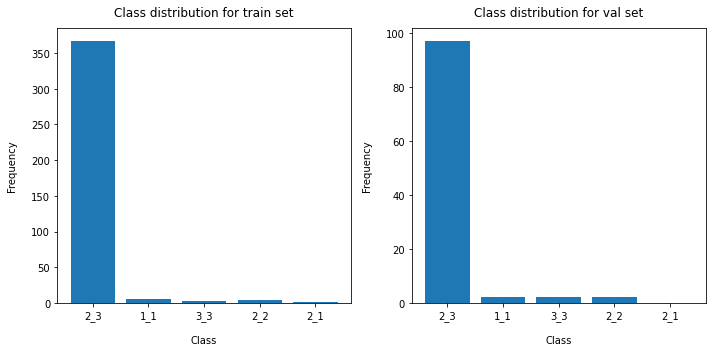

In [12]:
# Use seed=5 for 20_100 set and seed=15 for 50_100
ska_dataset.split_train_val(random_state=5, val_portion=0.2, balanced=False, size=350)

# Training

### Get FRCNN model

In [ ]:
rpn_model, detector_model, total_model = models.get_train_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model.summary()
detector_model.summary()
total_model.summary()

### Load weights

In [ ]:
checkpoint= 'loss_0_frcnn_baseline_16.h5'
models.load_weigths(rpn_model, detector_model, backbone, resume_train=False, checkpoint=checkpoint)

if use_focal_loss:
    models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.categorical_focal_loss(config.alpha, config.gamma), loss.detector_loss_regr], class_list=ska_dataset.class_list)
else:
    models.compile_models(rpn_model, detector_model, total_model, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)


In [ ]:
# If you want to specifically check backbone weights you need to slice weights tensors like this:
# total_model.weights[24:25][0][0][0][0]

In [ ]:
# Check that all of the pretrained weights have been loaded.
import numpy as np
for i, j in zip(total_model.weights, rpn_model.weights): 
    assert np.allclose(i,j), 'Weights don\'t match!'

### Train

In [ ]:
# Generating validation model for validation step at epoch's end
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

In [ ]:
from src.train import *

train_frcnn(rpn_model, detector_model, total_model, ska_dataset.train_patch_list, rpn_model_eval, detector_model_eval, total_model_eval, ska_dataset.val_patch_list, ska_dataset.class_list, num_epochs=120, patches_folder_path=config.TRAIN_PATCHES_FOLDER, backbone=backbone, resume_train=True)

# Validation

In [13]:
rpn_model_eval, detector_model_eval, total_model_eval = models.get_eval_model(input_shape_1=input_shape_1, input_shape_2=input_shape_2, input_shape_fmap=None, anchor_num=config.anchor_num, pooling_regions=config.pooling_regions, num_rois=config.num_rois, num_classes=len(ska_dataset.class_list)+1, backbone=backbone, use_expander=False)

rpn_model_eval.summary()
detector_model_eval.summary()
total_model_eval.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)    

In the following cell please select weights to be used to perform model evaluation

In [14]:
cp = 'map_63_frcnn_baseline_44.h5'

In [15]:
# Models used for mAP eval
models.load_weigths(rpn_model_eval, detector_model_eval, backbone, checkpoint=cp)
models.compile_models(rpn_model_eval, detector_model_eval, total_model_eval, rpn_losses=[loss.rpn_loss_cls, loss.rpn_loss_regr], detector_losses=[loss.detector_loss_cls, loss.detector_loss_regr], class_list=ska_dataset.class_list)

In [16]:
plist = ['14003_16486_17609_20', '8769_16616_17279_20', '14365_16926_17629_20']

preds, mAP, mPrecision, mRecall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, plist, ska_dataset.class_list, map_threshold=.5, acceptance_treshold=.5, save_eval_results=True)

100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Total model metrics: mAP: 15.87% - mPrecision: 5.56% - mRecall: 16.67%


In [ ]:
# Evaluation step carried out on the entire validation set

preds, mAP, mPrecision, mRecall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, ska_dataset.val_patch_list, ska_dataset.class_list, map_threshold=.5, acceptance_treshold=.5, save_eval_results=False)

In [ ]:
# Evaluation step carried out on the entire validation set

preds, mAP, mPrecision, mRecall = evaluate_model(rpn_model_eval, detector_model_eval, backbone, ska_dataset.train_patch_list, ska_dataset.class_list, map_threshold=.5, acceptance_treshold=.5, save_eval_results=False)

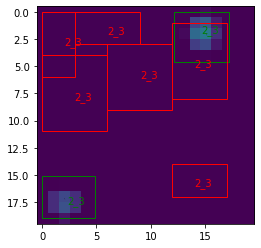

In [19]:
# Qualitative evaluation by printing image, ground truth and predicted bounding boxes
# patches used in the report for the 20_100 set: 14003_16486_17609_20, 8769_16616_17279_20, 14365_16926_17629_20
# patches used in the report for the 50_100 set: 
# patches used in the report for the 100_600 set: 
patch = '8769_16616_17279_20'

print_img(config.TRAIN_PATCHES_FOLDER, patch, config.EVAL_RESULTS, show_data=False)

# Plotting

### Loss plot

In [ ]:
loss_history = np.load(f"./model/{backbone}/loss_history.npy")
print(loss_history.shape)
plot_loss(loss_history[:])

### Evaluation metrics plot

In [ ]:
scores_history = np.load(f"./model/{backbone}/scores_history.npy")
print(scores_history.shape)
plot_scores(scores_history[:])


In [ ]:
lsma_0 = moving_average(loss_history[100:,2], 200)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, len(lsma_0)), lsma_0, 'r')
plt.title('rpn cls')
